# Packages and Modules

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Data analytics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import AnovaRM
from scipy.stats import mannwhitneyu
from sklearn import linear_model, svm, neighbors, ensemble, neural_network
from sklearn import gaussian_process
import scipy.stats as stats
import pingouin as pg
from pingouin import ttest

# Data pipeline for model fitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn import metrics

# Read in data

In [2]:
raw_data = pd.read_csv('../data/03_analytic/public_data.csv')
data = raw_data.copy()
data.head()

,Participant Number,source,credential,years_experience_aba,age,White,Black or African American,Other,gender,Clinic,Home,School,Residential,Other.1,0-5,6-10,11-20,21+,Other.2,population_ASD,population_disabilities_non_asd,other,low_low_low_low,low_low_med_low,low_low_high_low,low_low_low_med,low_low_med_med,low_low_high_med,low_low_low_high,low_low_med_high,low_low_high_high,low_med_low_low,low_med_med_low,low_med_high_low,low_med_low_med,low_med_med_med,low_med_high_med,low_med_low_high,low_med_med_high,low_med_high_high,low_high_low_low,low_high_med_low,low_high_high_low,low_high_low_med,low_high_med_med,low_high_high_med,low_high_low_high,low_high_med_high,low_high_high_high,low_low_low_low.1,med_low_med_low,med_low_high_low,med_low_low_med,med_low_med_med,med_low_high_med,med_low_low_high,med_low_med_high,med_low_high_high,med_med_low_low,med_med_med_low,med_med_high_low,med_med_low_med,med_med_med_med,med_med_high_med,med_med_low_high,med_med_med_high,med_med_high_high,med_high_low_low,med_high_med_low,med_high_high_low,med_high_low_med,med_high_med_med,med_high_high_med,med_high_low_high,med_high_med_high,med_high_high_high,high_low_low_low,high_low_med_low,high_low_high_low,high_low_low_med,high_low_med_med,high_low_high_med,high_low_low_high,high_low_med_high,high_low_high_high,high_med_low_low,high_med_med_low,high_med_high_low,high_med_low_med,high_med_med_med,high_med_high_med,high_med_low_high,high_med_med_high,high_med_high_high,high_high_low_low,high_high_med_low,high_high_high_low,high_high_low_med,high_high_med_med,high_high_high_med,high_high_low_high,high_high_med_high,high_high_high_high,strategy_used,experience_televisibility,experience_clients_harm
0,1,bx_analyst,2,23.0,41.0,1,0,0,Female,0,0,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1.0,1,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1.0,1,1,1.0,1,1,NaN,NaN,I think we need to look at everything we do as...,I have had extensive experience. I felt like I...
1,2,bx_analyst,2,9.0,34.0,1,0,0,Male,0,0,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1.0,1,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1.0,1,1,1.0,1,1,1.0,NaN,New York Times test,Very experienced in functional analysis of pro...
2,3,bx_analyst,1,8.0,36.0,1,0,0,Male,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1.0,1.0,1,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2,1,1,2,1,1.0,1,1,1,1.0,1,1.0,1,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2,2,1.0,1,2,2,1,1,1.0,1.0,1,1,1,2,2,2,2,2,1,1,1,1,2,2.0,2.0,2,2,2.0,1,1,1.0,NaN,New to me with this study.,"""Allowing"" is a difficult word. But, to the ex..."
3,4,bx_analyst,2,10.0,34.0,1,0,0,Female,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1.0,1,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,1.0,1,1,1.0,1,1,1.0,NaN,I frequently hear it in presentations and scho...,I have a lot of experience in this area workin...
4,5,bx_analyst,2,15.5,36.0,1,0,0,Female,0,0,1,0,0,0,1,1,0,0,1,0,1,1,2,2,1,1,1,1.0,1.0,1,2,2,2,1,2,2,1,1,1,2,2,2,2,2,2,1,2,2,2,1.0,2,1,1,1.0,1,1.0,1,1,2,2,1,1,1,1,1,1,2,2,2,2,2,2,1,1.0,1,1,2,1,1,1.0,1.0,1,1,1,2,2,2,1,1,1,1,1,1,2,2.0,2.0,2,2,2.0,2,1,1.0,NaN,I’ve heard it in this survey and in a few othe...,NaN


# Demographics

## Age

In [3]:
# Age
print("Behavior Analysts\n", data[data['source']=='bx_analyst']['age'].describe())
print("\nControl Group\n", data[data['source']=='gen_pop']['age'].describe())

Behavior Analysts
 count    14.000000
mean     38.857143
std       9.630538
min      26.000000
25%      34.000000
50%      36.000000
75%      40.750000
max      59.000000
Name: age, dtype: float64

Control Group
 count    30.000000
mean     32.766667
std      10.817238
min      19.000000
25%      24.250000
50%      31.500000
75%      39.750000
max      67.000000
Name: age, dtype: float64


### Did the groups differ in age?

In [4]:
# Isolate data for each group
bx_age = data[data['source']=='bx_analyst']['age'].dropna()
con_age = data[data['source']=='gen_pop']['age'].dropna()

# Run test using scipy
U, p = mannwhitneyu(bx_age, con_age, method='exact')
print(f"p-value = {round(p, 4)}")

p-value = 0.0755


#### No, they did not. 

## Race
- NB: Only races selected by participants are shown below.

In [5]:
# Race: Behavior Analysts
bx_df = data[data['source']=='bx_analyst']
for col in ['White', 'Black or African American', 'Other']:
    print(col, round(bx_df[col].sum()/len(bx_df), 4))

White 0.8667
Black or African American 0.0667
Other 0.0667


In [6]:
# Race: Control
gen_df = data[data['source']=='gen_pop']
for col in ['White', 'Black or African American', 'Other']:
    print(col, round(gen_df[col].sum()/len(gen_df), 4))

White 0.7333
Black or African American 0.3
Other 0.0333


### Did the groups differ in race?

In [7]:
for col in ['White', 'Black or African American', 'Other']:
    counts = np.array([bx_df[col].sum(), gen_df[col].sum()])
    nobs = np.array([len(bx_df), len(gen_df)])
    stat, pval = proportions_ztest(counts, nobs)
    print(f"{col} p-val = {round(pval, 4)}")

White p-val = 0.3105
Black or African American p-val = 0.0759
Other p-val = 0.609


#### No, they did not. 

## Gender
- NB: Only genders selected by participants are shown below. 

In [8]:
# Gender
print("Behavior Analysts\n", data[data['source']=='bx_analyst']['gender'].value_counts())
print("\nControl Group\n", data[data['source']=='gen_pop']['gender'].value_counts())

Behavior Analysts
 Female    10
Male       5
Name: gender, dtype: int64

Control Group
 Female    20
Male      10
Name: gender, dtype: int64


In [9]:
for gender in ['Male', 'Female']:
    counts = np.array([
        len(np.where(bx_df['gender']==gender)), 
        len(np.where(gen_df['gender']==gender))
    ])
    nobs = np.array([
        len(bx_df), 
        len(gen_df)
    ])
    stat, pval = proportions_ztest(counts, nobs)
    print(f"{gender} p-val = {round(pval, 4)}")

Male p-val = 0.609
Female p-val = 0.609


#### No, they did not. 

# Work settings and populations for behavior analysts

In [10]:
# Setting
for col in ['Clinic', 'Home', 'School', 'Residential', 'Other.1']:
    print(col, bx_df[col].sum(), round(bx_df[col].sum()/len(bx_df), 4))

Clinic 5 0.3333
Home 4 0.2667
School 6 0.4
Residential 1 0.0667
Other.1 2 0.1333


In [11]:
# Age groups
for col in ['0-5', '6-10', '11-20', '21+', 'Other.2']:
    print(col, bx_df[col].sum(), round(bx_df[col].sum()/len(bx_df), 4))

0-5 9 0.6
6-10 9 0.6
11-20 7 0.4667
21+ 6 0.4
Other.2 1 0.0667


In [12]:
# Diagnosis Population
for col in ['population_ASD', 'population_disabilities_non_asd', 'other']:
    print(col, bx_df[col].sum(), round(bx_df[col].sum()/len(bx_df), 4))

population_ASD 12 0.8
population_disabilities_non_asd 5 0.3333
other 5 0.3333


# Look at initial differences across questions

In [13]:
# Prep dataframe
plot_df = data[[col for col in list(data) if (col.startswith("low_")) or (col.startswith("med_")) or (col.startswith("high_")) or (col=='source') or (col=='Participant Number')]]
plot_df = plot_df.melt(id_vars=['source', 'Participant Number'])
plot_df.columns=['source', 'participant', 'scenario', 'choice']
plot_df[::300]

,source,participant,scenario,choice
0,bx_analyst,1,low_low_low_low,1.0
300,gen_pop,31,low_low_low_high,1.0
600,gen_pop,16,low_med_med_med,1.0
900,bx_analyst,1,low_high_high_low,1.0
1200,gen_pop,31,low_high_high_high,2.0
1500,gen_pop,16,med_low_low_high,1.0
1800,bx_analyst,1,med_med_med_med,1.0
2100,gen_pop,31,med_high_med_low,1.0
2400,gen_pop,16,med_high_high_high,1.0
2700,bx_analyst,1,high_low_low_high,1.0


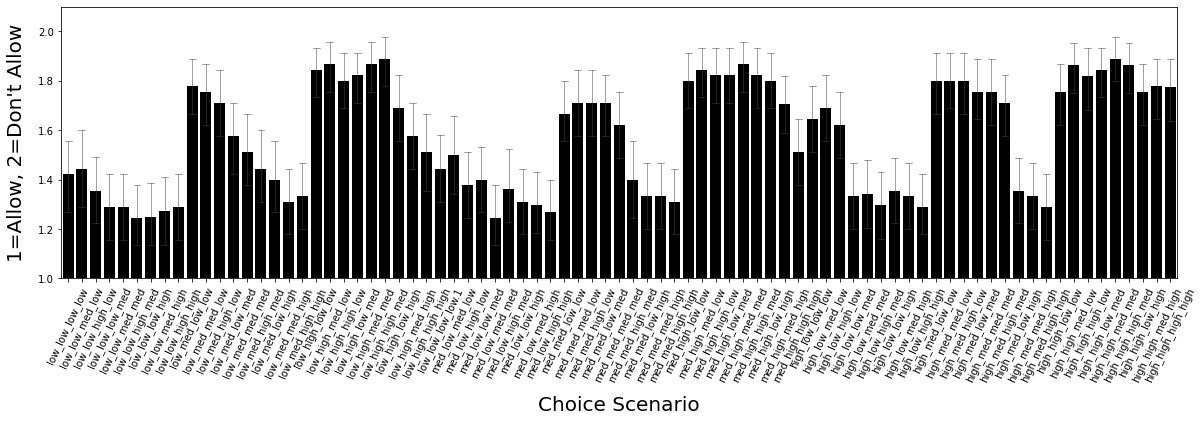

In [14]:
# All conditions all respondents
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='scenario', y='choice', data=plot_df, color='k', errwidth=.5, capsize=.5)
plt.xlabel("Choice Scenario", fontsize=20, labelpad=12)
plt.xticks(rotation=65)
plt.ylim(1, 2.1)
plt.ylabel("1=Allow, 2=Don't Allow", fontsize=20, labelpad=12)
plt.show()

#### There are some nice systematic patterns in there. Looks like we're on to something. 

In [15]:
# Make the long df easier to groupby different choice scenario characteristics
choice_char = []

for i in range(len(plot_df)):
    val = plot_df['scenario'][i].split("_")
    choice_char.append(val)

choice_char = pd.DataFrame(choice_char)
choice_char.columns = ['first_tele', 'first_harm', 'sec_tele', 'sec_harm']
plot_df = pd.concat([plot_df, choice_char], axis=1)
plot_df = plot_df.replace('low.1', 'low')
plot_df['source'] = plot_df['source'].replace({'bx_analyst':"Behavior Analyst", 
                                               'gen_pop': "Control Group"})
plot_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm
0,Behavior Analyst,1,low_low_low_low,1.0,low,low,low,low
1,Behavior Analyst,2,low_low_low_low,1.0,low,low,low,low
2,Behavior Analyst,3,low_low_low_low,1.0,low,low,low,low
3,Behavior Analyst,4,low_low_low_low,1.0,low,low,low,low
4,Behavior Analyst,5,low_low_low_low,1.0,low,low,low,low
...,...,...,...,...,...,...,...,...
3640,Control Group,41,high_high_high_high,2.0,high,high,high,high
3641,Control Group,42,high_high_high_high,2.0,high,high,high,high
3642,Control Group,43,high_high_high_high,2.0,high,high,high,high
3643,Control Group,44,high_high_high_high,2.0,high,high,high,high


# Plots of main effects

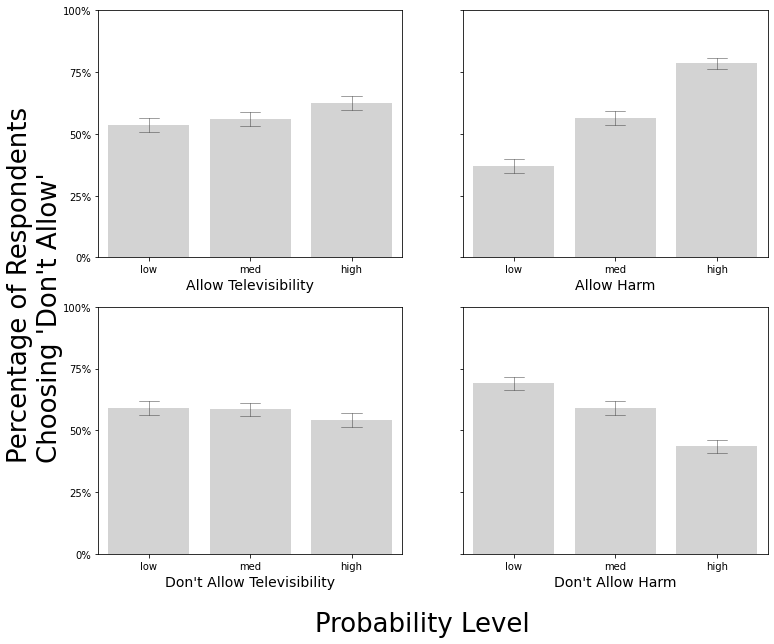

In [16]:
# Choice scenario characteristics
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10), sharey=True)

# Upper left
sns.barplot(ax=ax[0, 0], x='first_tele', y='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
ax[0, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[0, 0].set_ylabel("")
ax[0, 0].set_xlabel("Allow Televisibility", fontsize=14)

# Upper right
sns.barplot(ax=ax[0, 1], x='first_harm', y='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
ax[0, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("Allow Harm", fontsize=14)

# Bottom left
sns.barplot(ax=ax[1, 0], x='sec_tele', y='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
ax[1, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[1, 0].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
ax[1, 0].set_ylabel("")
ax[1, 0].set_xlabel("Don't Allow Televisibility", fontsize=14)

# Bottom right
sns.barplot(ax=ax[1, 1], x='sec_harm', y='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
ax[1, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[1, 1].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
ax[1, 1].set_ylabel("")
ax[1, 1].set_xlabel("Don't Allow Harm", fontsize=14)

fig.supxlabel("Probability Level", fontsize=26)
fig.supylabel("Percentage of Respondents\nChoosing 'Don't Allow'", fontsize=26)
plt.ylim(1, 2)
plt.show()

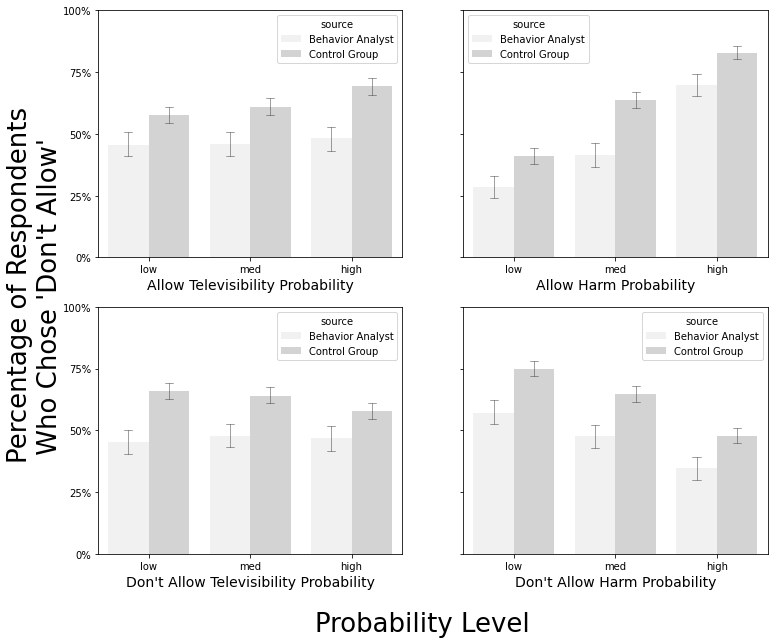

In [17]:
# Choices by scenario and group
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10), sharey=True,)

# Upper left
sns.barplot(ax=ax[0, 0], x='first_tele', y='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.08)
ax[0, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[1, 0].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
ax[0, 0].set_ylabel("")
ax[0, 0].set_xlabel("Allow Televisibility Probability", fontsize=14)

# Upper right
sns.barplot(ax=ax[0, 1], x='first_harm', y='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.08)
ax[0, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("Allow Harm Probability", fontsize=14)

# Bottom left
sns.barplot(ax=ax[1, 0], x="sec_tele", y='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.08)
ax[1, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[1, 0].set_ylabel("")
ax[1, 0].set_xlabel("Don't Allow Televisibility Probability", fontsize=14)

# Bottom right
sns.barplot(ax=ax[1, 1], x='sec_harm', y='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.08)
ax[1, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
ax[1, 1].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
ax[1, 1].set_ylabel("")
ax[1, 1].set_xlabel("Don't Allow Harm Probability", fontsize=14)

fig.supxlabel("Probability Level", fontsize=26)
fig.supylabel("Percentage of Respondents\n Who Chose 'Don't Allow'", fontsize=26)
plt.ylim(1, 2)
plt.show()

# Statistics

In [18]:
# Reshape the data for analyses
stats_df = plot_df.drop(['scenario'], axis=1)
stats_df = stats_df.melt(id_vars=['participant', 'source', 'choice'])
stats_df = stats_df.sort_values(by=['participant', 'variable', 'value']).reset_index(drop=True)
stats_df['condition'] = stats_df['variable'] + "_" + stats_df['value']
stats_df['source_condition'] = stats_df['source']+"_"+stats_df['condition']
stats_df

,participant,source,choice,variable,value,condition,source_condition
0,1,Behavior Analyst,1.0,first_harm,high,first_harm_high,Behavior Analyst_first_harm_high
1,1,Behavior Analyst,1.0,first_harm,high,first_harm_high,Behavior Analyst_first_harm_high
2,1,Behavior Analyst,1.0,first_harm,high,first_harm_high,Behavior Analyst_first_harm_high
3,1,Behavior Analyst,1.0,first_harm,high,first_harm_high,Behavior Analyst_first_harm_high
4,1,Behavior Analyst,1.0,first_harm,high,first_harm_high,Behavior Analyst_first_harm_high
...,...,...,...,...,...,...,...
14575,45,Control Group,1.0,sec_tele,med,sec_tele_med,Control Group_sec_tele_med
14576,45,Control Group,2.0,sec_tele,med,sec_tele_med,Control Group_sec_tele_med
14577,45,Control Group,2.0,sec_tele,med,sec_tele_med,Control Group_sec_tele_med
14578,45,Control Group,2.0,sec_tele,med,sec_tele_med,Control Group_sec_tele_med


In [19]:
# Test for main effects
pg.mixed_anova(dv='choice', 
               between='source', 
               within='condition', 
               subject='participant', 
               data=stats_df)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,source,3.096516,1,43,3.096516,4.164124,4.745881e-02,0.088290,NaN
1,condition,5.588147,11,473,0.508013,32.676028,1.982517e-51,0.431788,0.244097
2,Interaction,0.162184,11,473,0.014744,0.948351,4.933781e-01,0.021579,NaN


In [20]:
# Test overall within behavior analysts
model_df = stats_df[stats_df['source']=='Behavior Analyst'].reset_index(drop=True)
pg.rm_anova(data = model_df, 
            dv = 'choice', 
            within = 'condition', 
            subject = 'participant')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condition,11,154,9.618048,4.288782e-13,0.407233,0.250109


In [21]:
# Allow televisiblity
for prob in ['first_tele', 'first_harm', 'sec_tele', 'sec_harm']:
    print(prob)
    print(pg.rm_anova(data = model_df[model_df['variable']==prob], 
                dv = 'choice', 
                within = 'condition', 
                subject = 'participant'), "\n")

first_tele
      Source  ddof1  ddof2         F     p-unc  p-GG-corr      np2       eps  \
0  condition      2     28  0.345879  0.710579   0.638545  0.02411  0.708376   

   sphericity  W-spher   p-spher  
0       False  0.58832  0.031804   

first_harm
      Source  ddof1  ddof2          F     p-unc  p-GG-corr      np2       eps  \
0  condition      2     28  16.671507  0.000017   0.000165  0.54355  0.727001   

   sphericity   W-spher   p-spher  
0       False  0.624487  0.046871   

sec_tele
      Source  ddof1  ddof2         F     p-unc  p-GG-corr       np2       eps  \
0  condition      2     28  0.486403  0.619933   0.553944  0.033576  0.692011   

   sphericity   W-spher   p-spher  
0       False  0.554936  0.021756   

sec_harm
      Source  ddof1  ddof2         F     p-unc  p-GG-corr       np2       eps  \
0  condition      2     28  5.097845  0.012942   0.035922  0.266933  0.551957   

   sphericity   W-spher   p-spher  
0       False  0.188266  0.000019   



In [22]:
# Test within general popoulation
model_df = stats_df[stats_df['source']=='Control Group'].reset_index(drop=True)
pg.rm_anova(data = model_df, 
            dv = 'choice', 
            within = 'condition', 
            subject = 'participant')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condition,11,319,24.098686,6.301067e-36,0.453847,0.210807


In [23]:
# Allow televisiblity
for prob in ['first_tele', 'first_harm', 'sec_tele', 'sec_harm']:
    print(prob)
    print(pg.rm_anova(data = model_df[model_df['variable']==prob], 
                dv = 'choice', 
                within = 'condition', 
                subject = 'participant'), "\n")

first_tele
      Source  ddof1  ddof2          F     p-unc       np2       eps
0  condition      2     58  10.444293  0.000134  0.264786  0.954227 

first_harm
      Source  ddof1  ddof2          F         p-unc     p-GG-corr       np2  \
0  condition      2     58  43.727417  2.632056e-12  7.722574e-09  0.601251   

       eps  sphericity   W-spher   p-spher  
0  0.65666       False  0.477142  0.000032   

sec_tele
      Source  ddof1  ddof2       F     p-unc  p-GG-corr       np2       eps  \
0  condition      2     58  7.3121  0.001472    0.00464  0.201368  0.717751   

   sphericity   W-spher   p-spher  
0       False  0.606759  0.000917   

sec_harm
      Source  ddof1  ddof2          F     p-unc  p-GG-corr       np2  \
0  condition      2     58  15.471221  0.000004   0.000304  0.347893   

        eps  sphericity   W-spher       p-spher  
0  0.547363       False  0.173059  2.161282e-11   



In [24]:
# Test just for the effect of harm
model_df = stats_df[stats_df['variable'].isin(['first_harm', 'sec_harm'])]
print("Conditions: ", model_df['condition'].unique())
pg.mixed_anova(dv='choice', 
               between='source', 
               within='condition', 
               subject='participant', 
               data=model_df)

Conditions:  ['first_harm_high' 'first_harm_low' 'first_harm_med' 'sec_harm_high'
 'sec_harm_low' 'sec_harm_med']


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,source,1.540787,1,43,1.540787,4.144468,4.796171e-02,0.087910,NaN
1,condition,5.335184,5,215,1.067037,38.528817,3.813388e-28,0.472579,0.390871
2,Interaction,0.072856,5,215,0.014571,0.526141,7.563579e-01,0.012088,NaN


In [25]:
# Test just for the effect of televisibility
model_df = stats_df[stats_df['variable'].isin(['first_tele', 'sec_tele'])]
print("Conditions: ", model_df['condition'].unique())
pg.mixed_anova(dv='choice', 
               between='source', 
               within='condition', 
               subject='participant', 
               data=model_df)

Conditions:  ['first_tele_high' 'first_tele_low' 'first_tele_med' 'sec_tele_high'
 'sec_tele_low' 'sec_tele_med']


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,source,1.555747,1,43,1.555747,4.183787,4.696153e-02,0.088670,NaN
1,condition,0.252960,5,215,0.050592,7.773636,9.615962e-07,0.153104,0.483896
2,Interaction,0.089310,5,215,0.017862,2.744551,1.994796e-02,0.059997,NaN


In [26]:
# Get all pairwise combinations of conditions
paired_list = itertools.combinations(stats_df['source_condition'].unique(), 2)
paired_list = list(paired_list)
print(len(paired_list))
paired_list

276


[('Behavior Analyst_first_harm_high', 'Behavior Analyst_first_harm_low'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_first_harm_med'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_first_tele_high'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_first_tele_low'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_first_tele_med'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_harm_high'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_harm_low'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_harm_med'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_tele_high'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_tele_low'),
 ('Behavior Analyst_first_harm_high', 'Behavior Analyst_sec_tele_med'),
 ('Behavior Analyst_first_harm_high', 'Control Group_first_harm_high'),
 ('Behavior Analyst_first_harm_high', 'Control Group_first_harm_low'),
 ('Behavior Analyst_first_harm_high', 'Control Group

In [27]:
# Get all pairwise comparisons that are significant
comparison = []
pval = []

for pair in paired_list:
    first_data = stats_df[stats_df['source_condition']==pair[0]]
    second_data = stats_df[stats_df['source_condition']==pair[1]]
    output = pd.DataFrame(ttest(first_data['choice'], second_data['choice'])).reset_index(drop=True)
    if output['p-val'][0]<=0.05/276:
        comparison.append(pair)
        pval.append(output['p-val'][0])
    else:
        continue

pair_df_results = pd.DataFrame([comparison, pval]).T
pair_df_results.columns = ['comparison', 'pval']
pair_df_results = pair_df_results.sort_values(by='pval').reset_index(drop=True)
pair_df_results.to_csv('../data/04_model_outputs/paired_ttest_results.csv')

In [28]:
# Check for statistical significance using logistic regression models
features = plot_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
fit_dict = {'Behavior Analyst':0, 'Control Group':1, 
            'low':0, 'med':1, 'high':2}
features = features.replace(fit_dict)
dv = plot_df['choice']
dv = dv.replace(1, 0)
dv = dv.replace(2, 1)
log_res = sm.Logit(dv, features, missing='drop').fit()
print(log_res.summary())

Optimization terminated successfully.
         Current function value: 0.582318
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 3633
Model:                          Logit   Df Residuals:                     3628
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Sep 2022   Pseudo R-squ.:                  0.1468
Time:                        12:42:03   Log-Likelihood:                -2115.6
converged:                       True   LL-Null:                       -2479.6
Covariance Type:            nonrobust   LLR p-value:                3.036e-156
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
source         0.5770      0.069      8.349      0.000       0.442       0.712
first_tele     0.1194      0.

In [29]:
# Convert entire df to numbers
num_df = plot_df.replace(fit_dict)
num_df['choice'] = num_df['choice'].replace(1, 0)
num_df['choice'] = num_df['choice'].replace(2, 1)
num_df.dropna(inplace=True)
num_df = num_df.reset_index(drop=True)
num_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm
0,0,1,low_low_low_low,0.0,0,0,0,0
1,0,2,low_low_low_low,0.0,0,0,0,0
2,0,3,low_low_low_low,0.0,0,0,0,0
3,0,4,low_low_low_low,0.0,0,0,0,0
4,0,5,low_low_low_low,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
3628,1,41,high_high_high_high,1.0,2,2,2,2
3629,1,42,high_high_high_high,1.0,2,2,2,2
3630,1,43,high_high_high_high,1.0,2,2,2,2
3631,1,44,high_high_high_high,1.0,2,2,2,2


In [30]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=num_df).fit()
print(reg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 choice   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     172.6
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          4.17e-165
Time:                        12:42:03   Log-Likelihood:                -2210.2
No. Observations:                3633   AIC:                             4432.
Df Residuals:                    3627   BIC:                             4470.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3703      0.022     16.936      0.0

In [31]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=plot_df).fit()
print(reg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 choice   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     96.80
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          2.07e-162
Time:                        12:42:03   Log-Likelihood:                -2206.4
No. Observations:                3633   AIC:                             4433.
Df Residuals:                    3623   BIC:                             4495.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# Above fits weren't great. Can we do better with ML?

In [32]:
# Prep data
features = num_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
outc = num_df['choice']

### Trying classification

In [33]:
# %% Functions
def fit_algo(model, features, outcome, save_name):
    scoring = {"Accuracy": "accuracy",
               "Precision": "precision",
               "ROC-AUC": "roc_auc", 
               "F1": "f1", 
               "Recall": "recall", 
              }
    cv = RepeatedKFold(n_splits=5,
                       n_repeats=10,
                       random_state=431979)
    scores = cross_validate(estimator=model,
                            X=features,
                            y=outcome,
                            groups=None,
                            scoring=scoring,
                            cv=cv,
                            n_jobs=1,
                            verbose=0)
    scores = pd.DataFrame(scores)
    scores['model'] = save_name
    scores.to_csv(f"../data/04_model_outputs/classification/{save_name}.csv")
    print(f"Accuracy:  AVG: {abs(round(scores.test_Accuracy.mean(), 6))}; MAX: {abs(round(scores.test_Accuracy.max(), 6))}; MIN: {abs(round(scores.test_Accuracy.min(), 6))}")
    print(f"Precision: AVG: {abs(round(scores.test_Precision.mean(), 6))}; MAX: {abs(round(scores.test_Precision.max(), 6))}; MIN: {abs(round(scores.test_Precision.min(), 6))}")
    print(f"Recall:    AVG: {abs(round(scores.test_Recall.mean(), 6))}; MAX: {abs(round(scores.test_Recall.max(), 6))}; MIN: {abs(round(scores.test_Recall.min(), 6))}")
    print(f"F1:        AVG: {round(scores.test_F1.mean(), 6)}; MAX: {round(scores.test_F1.max(), 6)}; MIN: {round(scores.test_F1.min(), 6)}")
    print(f"ROC-AUC:   AVG: {round(scores['test_ROC-AUC'].mean(), 6)}; MAX: {round(scores['test_ROC-AUC'].max(), 6)}; MIN: {round(scores['test_ROC-AUC'].min(), 6)}")
    return scores

In [34]:
# Set of all models to test
models = {"Logistic Regression": linear_model.LogisticRegression(solver='liblinear', penalty='l2'), 
          "kNN Classifier": neighbors.KNeighborsClassifier(n_neighbors=100),
          "Support Vector Classifier": svm.SVC(C=1.0, kernel='rbf'),
          "Stochastic Gradient Classifier": linear_model.SGDClassifier(learning_rate='optimal'),
          "Gaussian Process Classifier": gaussian_process.GaussianProcessClassifier(), 
          "Random Forest Classifier": ensemble.RandomForestClassifier(),
          "AdaBoost Classifier": ensemble.AdaBoostClassifier(),
          "Gradient Boosting Classifier": ensemble.GradientBoostingClassifier()}

In [35]:
# Run through the list of models for all outcomes
import warnings
warnings.filterwarnings("ignore")

all_results = pd.DataFrame()

for key, value in models.items():
    print(f"Fitting {key}")
    results = fit_algo(model=value,
                       features=features,
                       outcome=outc,
                       save_name=key)
    all_results = pd.concat([all_results, results])
    print("\n")

all_results.to_csv('../data/04_model_outputs/all_results_cross_val_classification.csv')

Fitting Logistic Regression
Accuracy:  AVG: 0.709192; MAX: 0.740028; MIN: 0.681818
Precision: AVG: 0.725115; MAX: 0.768374; MIN: 0.671706
Recall:    AVG: 0.793182; MAX: 0.84058; MIN: 0.756563
F1:        AVG: 0.757413; MAX: 0.784; MIN: 0.730047
ROC-AUC:   AVG: 0.76336; MAX: 0.794731; MIN: 0.735759


Fitting kNN Classifier
Accuracy:  AVG: 0.705972; MAX: 0.731774; MIN: 0.671252
Precision: AVG: 0.732622; MAX: 0.770686; MIN: 0.668161
Recall:    AVG: 0.76746; MAX: 0.808354; MIN: 0.731884
F1:        AVG: 0.749251; MAX: 0.773303; MIN: 0.713772
ROC-AUC:   AVG: 0.755301; MAX: 0.783357; MIN: 0.720931


Fitting Support Vector Classifier
Accuracy:  AVG: 0.709137; MAX: 0.735901; MIN: 0.682256
Precision: AVG: 0.746938; MAX: 0.791667; MIN: 0.688995
Recall:    AVG: 0.744605; MAX: 0.786385; MIN: 0.714286
F1:        AVG: 0.745547; MAX: 0.771395; MIN: 0.713755
ROC-AUC:   AVG: 0.747438; MAX: 0.779674; MIN: 0.714334


Fitting Stochastic Gradient Classifier
Accuracy:  AVG: 0.669858; MAX: 0.744154; MIN: 0.469

In [36]:
# Get the range for each model fit
all_results.groupby(by=['model']).max() - all_results.groupby(by=['model']).min()

,fit_time,score_time,test_Accuracy,test_Precision,test_ROC-AUC,test_F1,test_Recall
model,,,,,,,
AdaBoost Classifier,0.051409,0.010510,0.060962,0.087646,0.055470,0.055989,0.076190
Gaussian Process Classifier,0.408913,0.131506,0.067400,0.111225,0.057929,0.074087,0.102510
Gradient Boosting Classifier,0.051426,0.005466,0.056396,0.102240,0.056625,0.060386,0.094077
Logistic Regression,0.003259,0.003097,0.058209,0.096668,0.058972,0.053953,0.084016
Random Forest Classifier,0.070361,0.035765,0.060523,0.118106,0.051412,0.067113,0.085357
Stochastic Gradient Classifier,0.006752,0.003591,0.275103,0.342214,0.071340,0.605694,0.879079
Support Vector Classifier,0.090298,0.059377,0.053645,0.102671,0.065340,0.057640,0.072099
kNN Classifier,0.003319,0.030998,0.060523,0.102524,0.062426,0.059530,0.076470


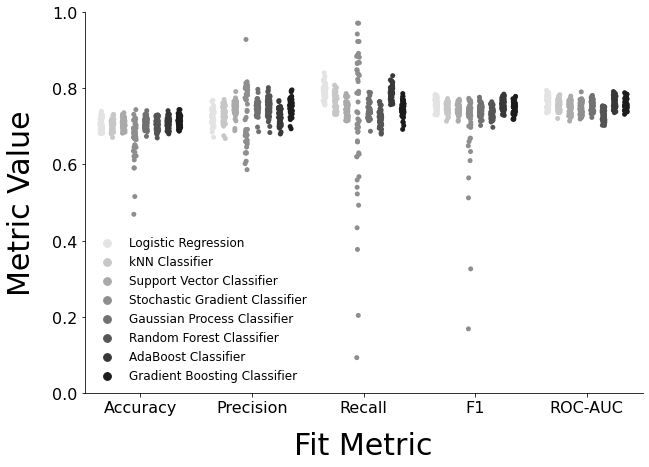

In [37]:
# Graph the results
class_df = all_results.melt(id_vars=['model'])
class_df = class_df[class_df['variable']!='fit_time']
class_df = class_df[class_df['variable']!='score_time'].reset_index(drop=True)
class_df = class_df[class_df['model']!='Multilayer Perceptron'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 7))
sns.stripplot(x='variable', y='value', hue='model', data=class_df, dodge=True, palette='binary', order=['test_Accuracy', 'test_Precision', 'test_Recall', 'test_F1', 'test_ROC-AUC'])
plt.xlabel("Fit Metric", fontsize=30, labelpad=16)
plt.ylabel("Metric Value", fontsize=30, labelpad=16)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.savefig(f'../figures/classification_results_overall.png', bbox_inches='tight')
plt.show()

### Beta coefficients for logistic regression models b/c it performed well and is, arguably, the simplest/most parsimonious

In [38]:
lr_model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', random_state=431979)
lr_model.fit(features, outc)
coefs = pd.DataFrame()
coefs['coefs'] = lr_model.coef_[0]
coefs['variable'] = list(features)
coefs

,coefs,variable
0,0.784730,source
1,0.217459,first_tele
2,0.990795,first_harm
3,-0.131340,sec_tele
4,-0.639873,sec_harm


# Within-Subject Analyses

In [39]:
# Setup col that contains a summary of the total risk in the situation
num_df['risk'] = num_df[['first_tele', 'first_harm', 'sec_tele', 'sec_harm']].sum(axis=1)
plot_df['risk'] = num_df['risk']
plot_df = plot_df.replace("low_low_low_low.1", "low_low_low_low")
plot_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm,risk
0,Behavior Analyst,1,low_low_low_low,1.0,low,low,low,low,0.0
1,Behavior Analyst,2,low_low_low_low,1.0,low,low,low,low,0.0
2,Behavior Analyst,3,low_low_low_low,1.0,low,low,low,low,0.0
3,Behavior Analyst,4,low_low_low_low,1.0,low,low,low,low,0.0
4,Behavior Analyst,5,low_low_low_low,1.0,low,low,low,low,0.0
...,...,...,...,...,...,...,...,...,...
3640,Control Group,41,high_high_high_high,2.0,high,high,high,high,NaN
3641,Control Group,42,high_high_high_high,2.0,high,high,high,high,NaN
3642,Control Group,43,high_high_high_high,2.0,high,high,high,high,NaN
3643,Control Group,44,high_high_high_high,2.0,high,high,high,high,NaN


In [40]:
plot_df.replace({'low':0, 'med':1, 'high':2}, inplace=True)
plot_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm,risk
0,Behavior Analyst,1,low_low_low_low,1.0,0,0,0,0,0.0
1,Behavior Analyst,2,low_low_low_low,1.0,0,0,0,0,0.0
2,Behavior Analyst,3,low_low_low_low,1.0,0,0,0,0,0.0
3,Behavior Analyst,4,low_low_low_low,1.0,0,0,0,0,0.0
4,Behavior Analyst,5,low_low_low_low,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
3640,Control Group,41,high_high_high_high,2.0,2,2,2,2,NaN
3641,Control Group,42,high_high_high_high,2.0,2,2,2,2,NaN
3642,Control Group,43,high_high_high_high,2.0,2,2,2,2,NaN
3643,Control Group,44,high_high_high_high,2.0,2,2,2,2,NaN


In [41]:
def plot_indiv(df, part=None):
    # Setup df for participant
    temp_df = df[df['participant']==part].dropna().reset_index(drop=True)

    # Choice scenario characteristics
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10), sharey=True)

    # Upper left
    sns.barplot(ax=ax[0, 0], x='first_tele', y='choice', data=temp_df, color='lightgray', errwidth=.5, capsize=.2)
    ax[0, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
    ax[0, 0].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
    ax[0, 0].set_ylabel("")
    ax[0, 0].set_xticks([0, 1, 2])
    ax[0, 0].set_xticklabels(labels=['low', 'med', 'high'])
    ax[0, 0].set_xlabel("Allow Televisibility", fontsize=14)

    # Upper right
    sns.barplot(ax=ax[0, 1], x='first_harm', y='choice', data=temp_df, color='lightgray', errwidth=.5, capsize=.2)
    ax[0, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
    ax[0, 1].set_ylabel("")
    ax[0, 1].set_xticks([0, 1, 2])
    ax[0, 1].set_xticklabels(labels=['low', 'med', 'high'])
    ax[0, 1].set_xlabel("Allow Harm", fontsize=14)

    # Bottom left
    sns.barplot(ax=ax[1, 0], x='sec_tele', y='choice', data=temp_df, color='lightgray', errwidth=.5, capsize=.2)
    ax[1, 0].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
    ax[1, 0].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
    ax[1, 0].set_ylabel("")
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xticklabels(labels=['low', 'med', 'high'])
    ax[1, 0].set_xlabel("Don't Allow Televisibility", fontsize=14)

    # Bottom right
    sns.barplot(ax=ax[1, 1], x='sec_harm', y='choice', data=temp_df, color='lightgray', errwidth=.5, capsize=.2)
    ax[1, 1].set_yticks([1, 1.25, 1.50, 1.75, 2.0])
    ax[1, 1].set_yticklabels(labels=['0%', '25%', '50%', '75%', '100%'])
    ax[1, 1].set_ylabel("")
    ax[1, 1].set_xticks([0, 1, 2])
    ax[1, 1].set_xticklabels(labels=['low', 'med', 'high'])
    ax[1, 1].set_xlabel("Don't Allow Harm", fontsize=14)

    fig.supxlabel("Probability Level", fontsize=26)
    fig.supylabel("Percentage of Choices to 'Don't Allow'", fontsize=26)
    plt.ylim(0.95, 2.05)
    plt.savefig(f"../figures/individual_plots/indiv_plot_{part}.png", bbox_inches='tight')
    plt.show()

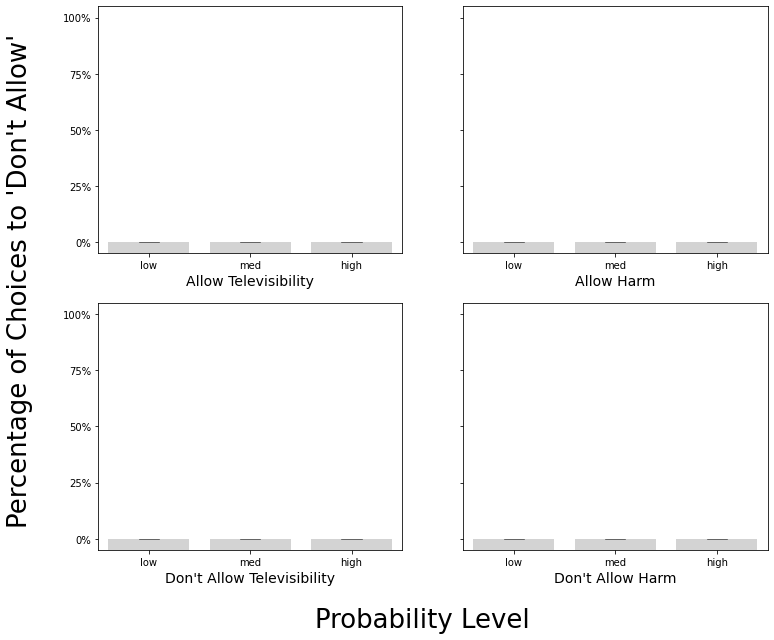

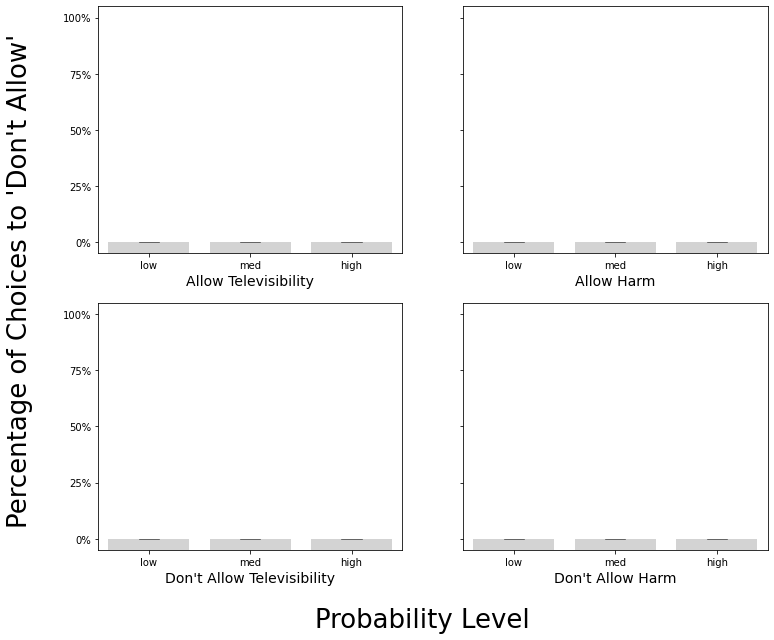

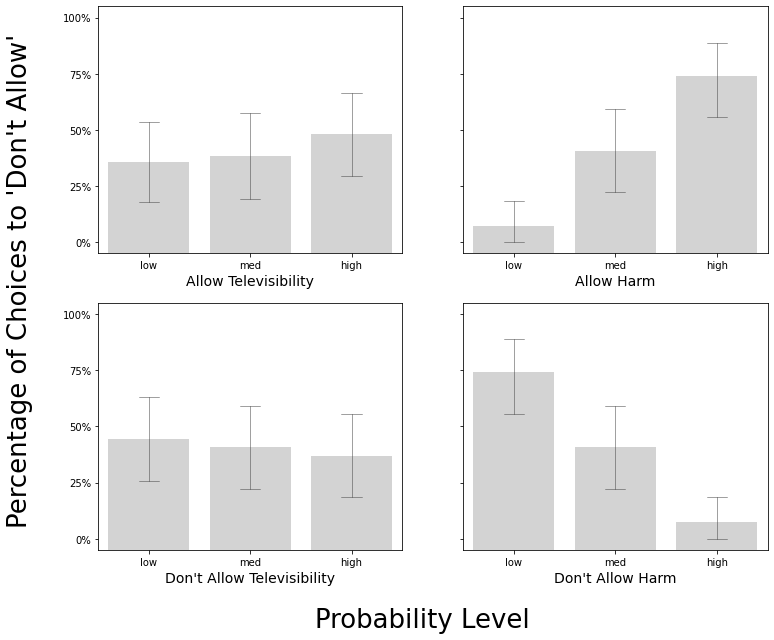

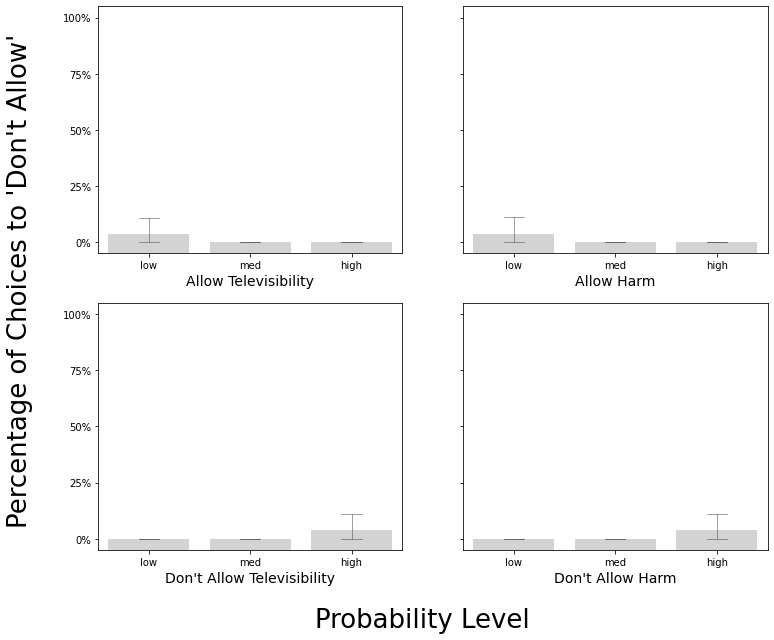

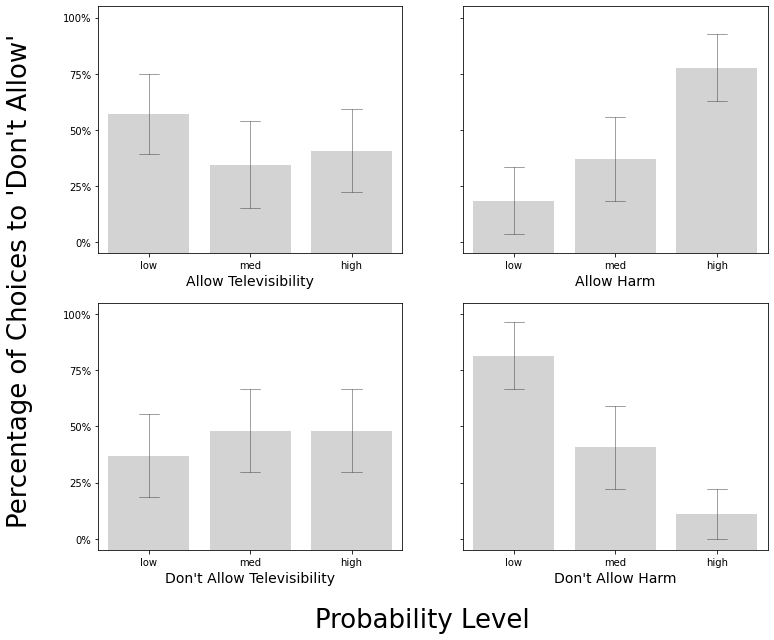

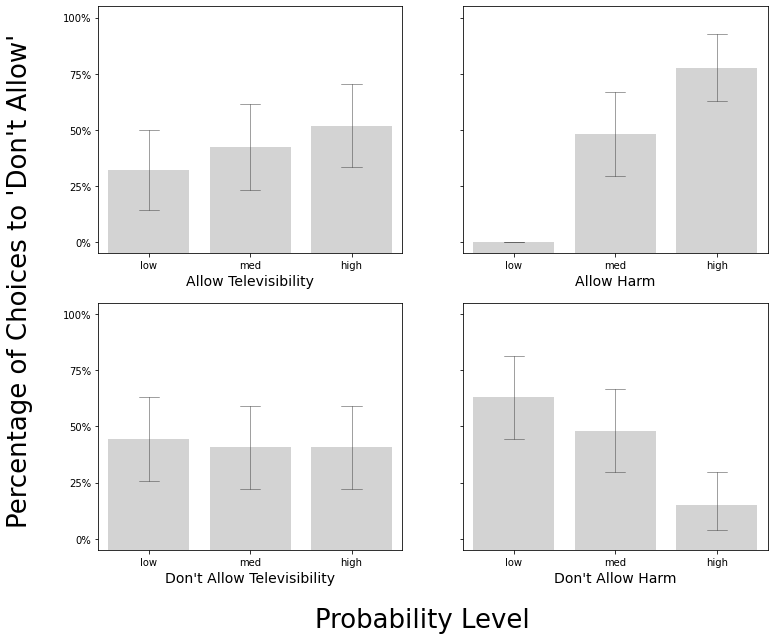

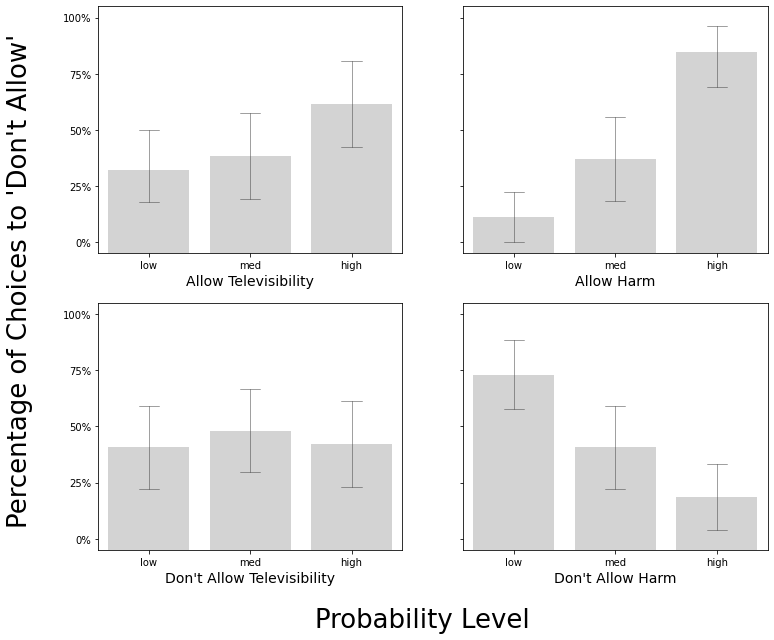

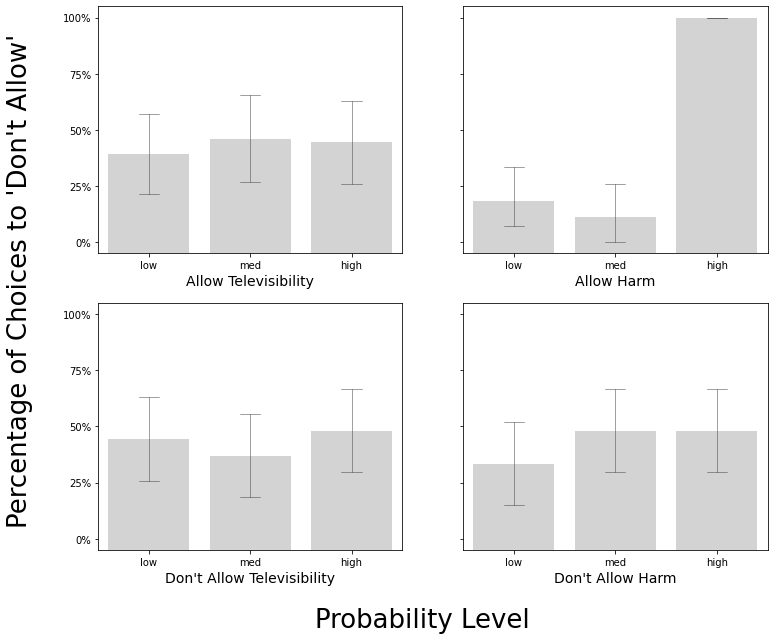

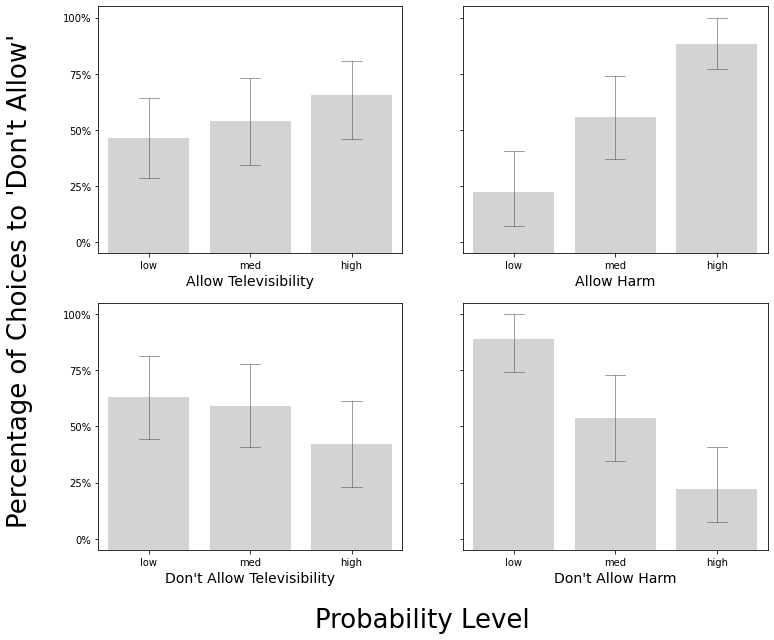

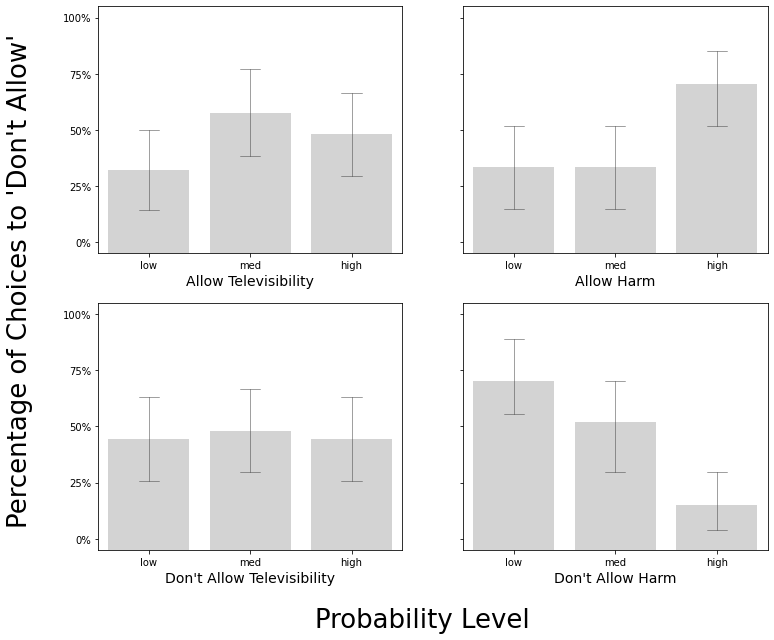

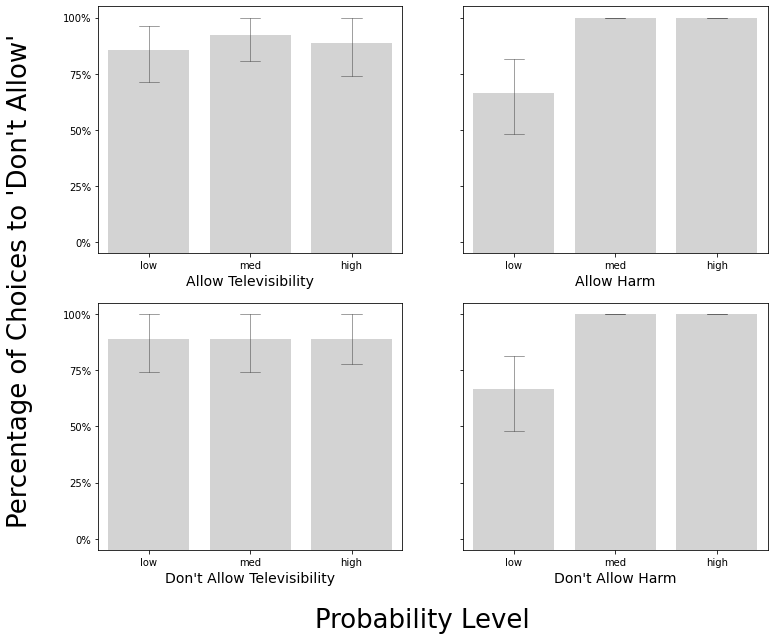

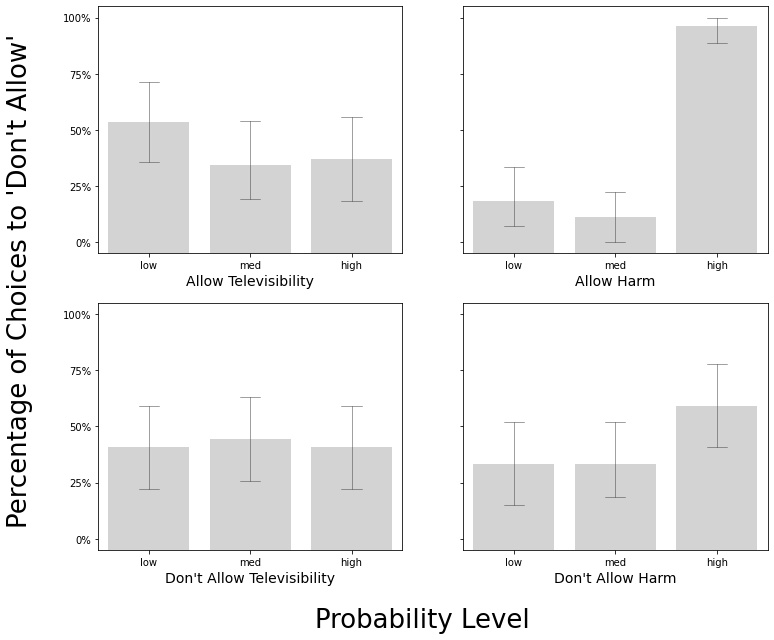

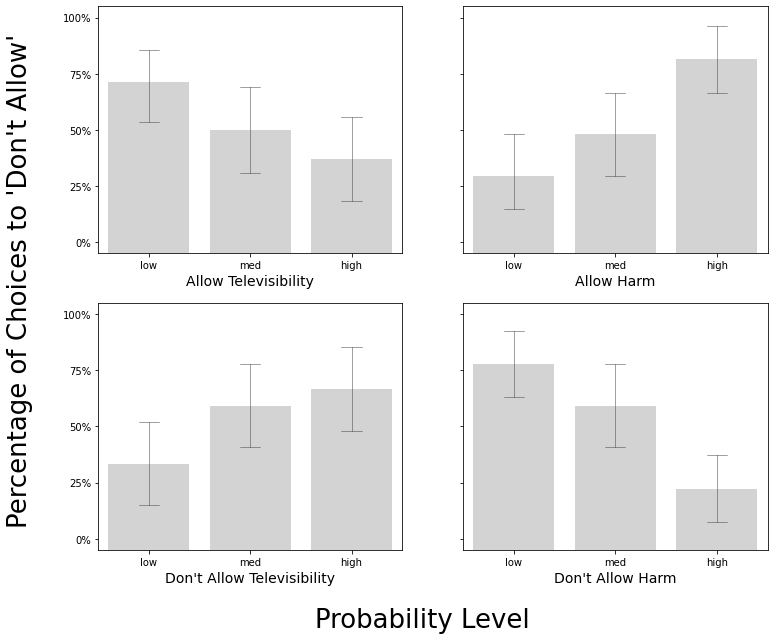

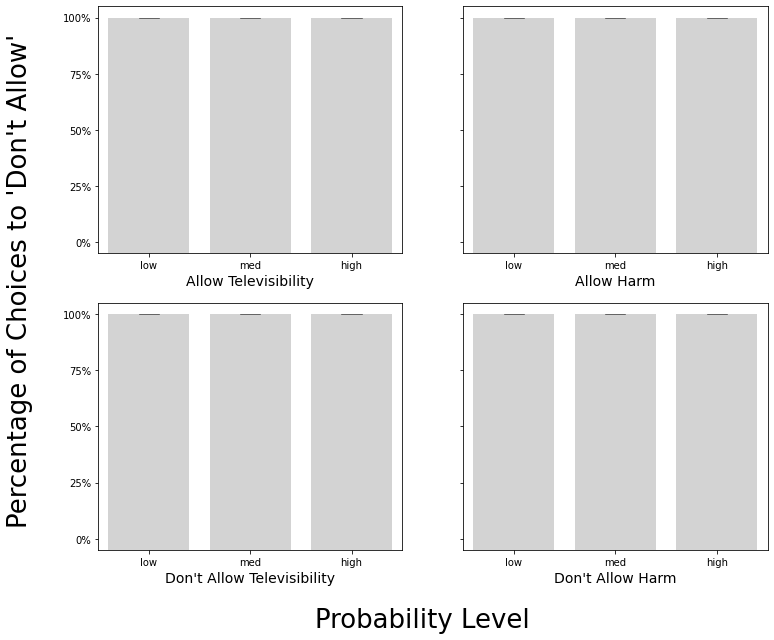

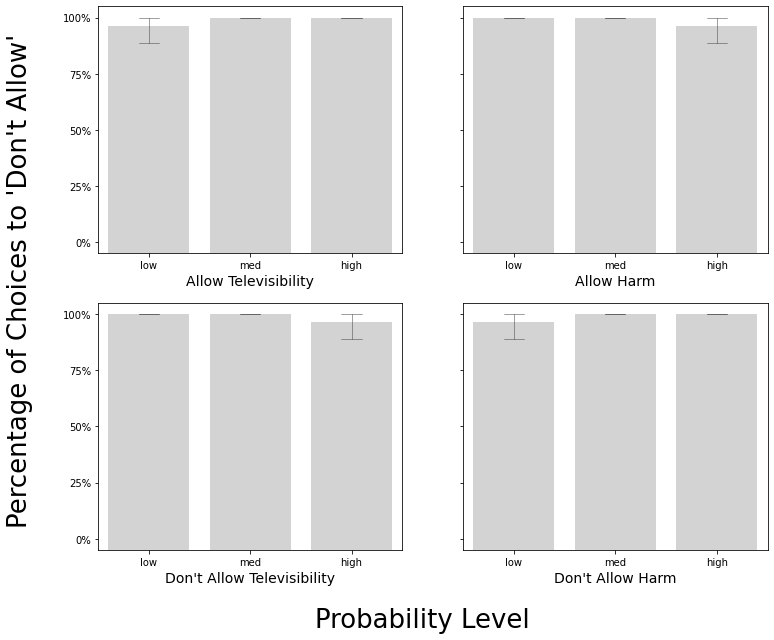

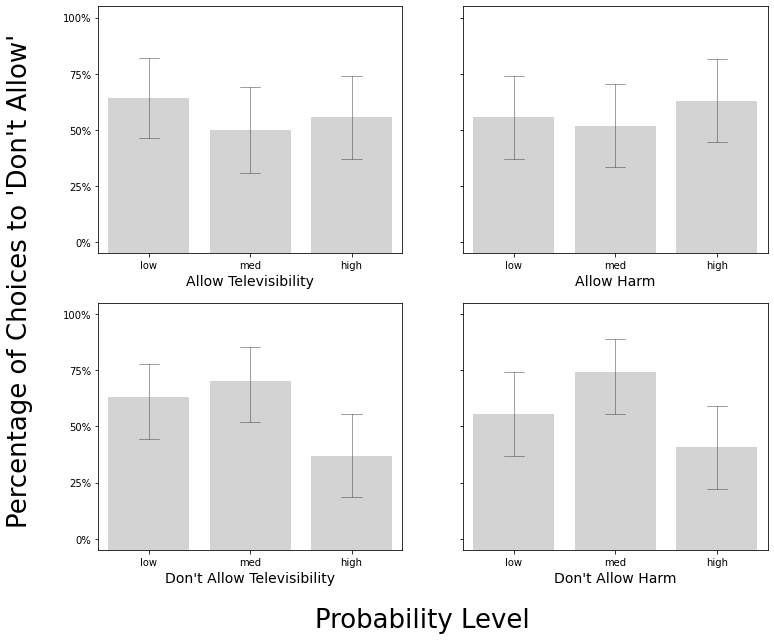

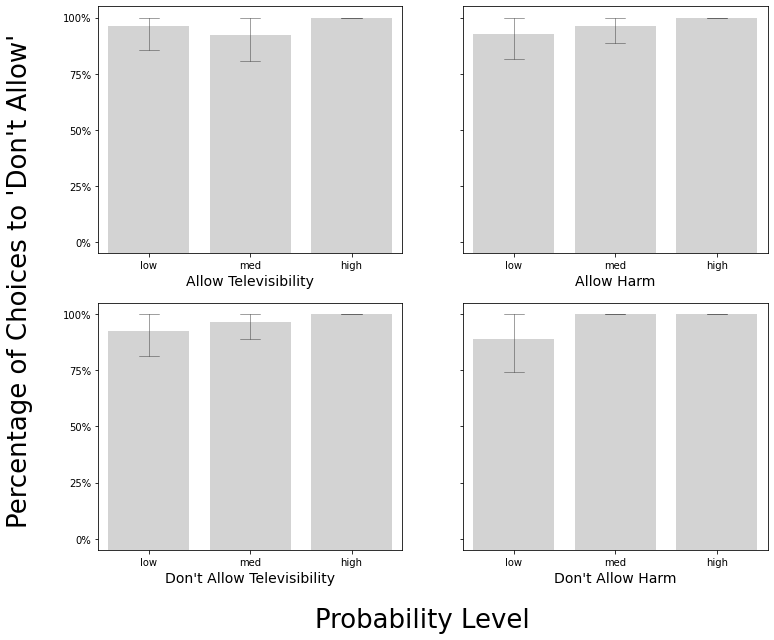

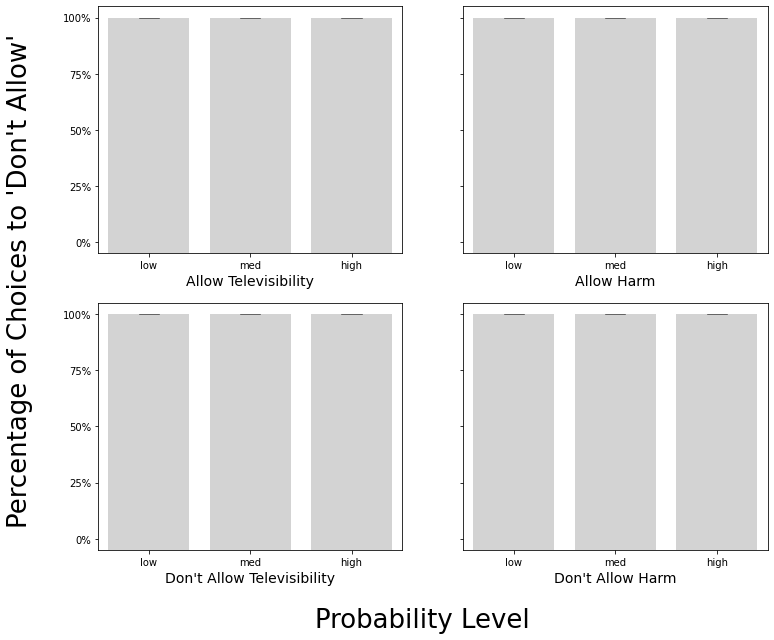

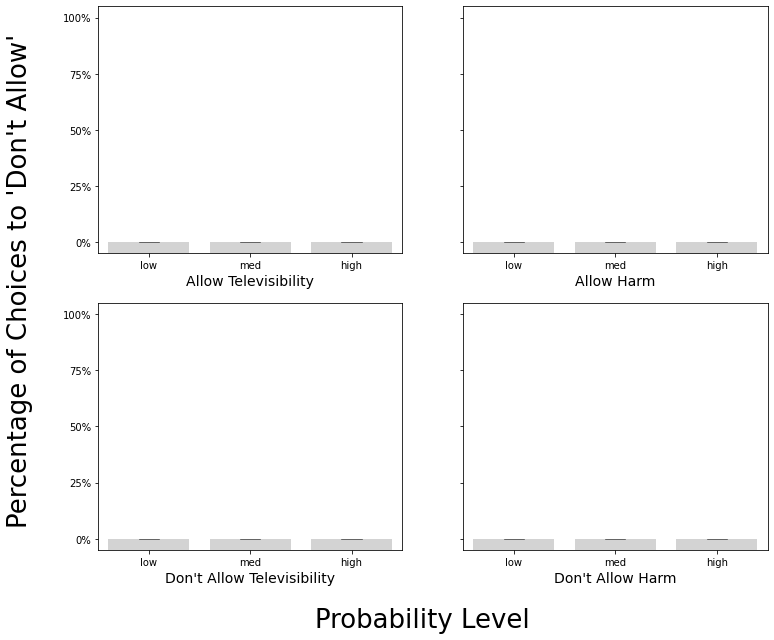

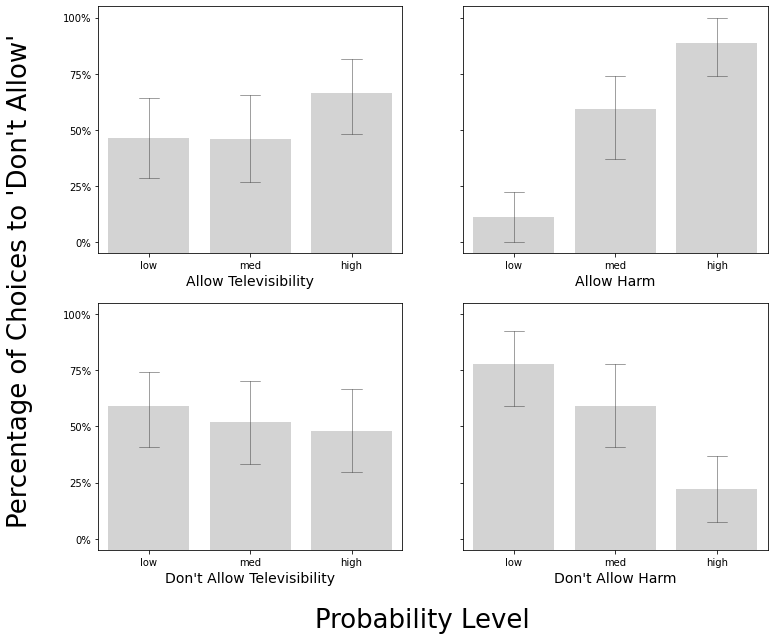

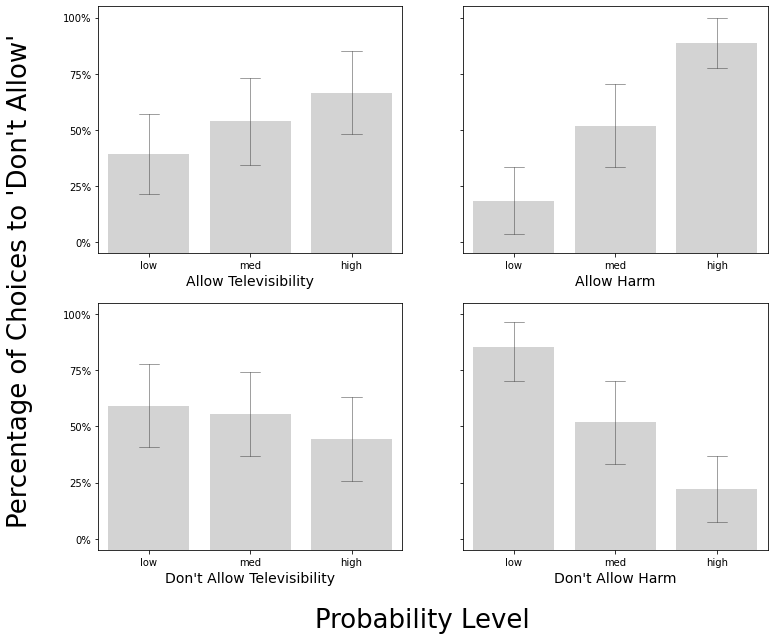

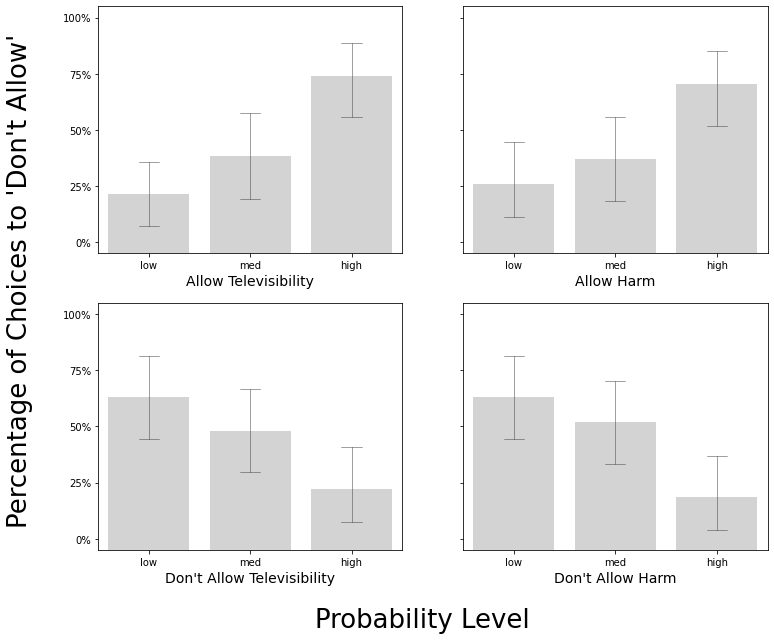

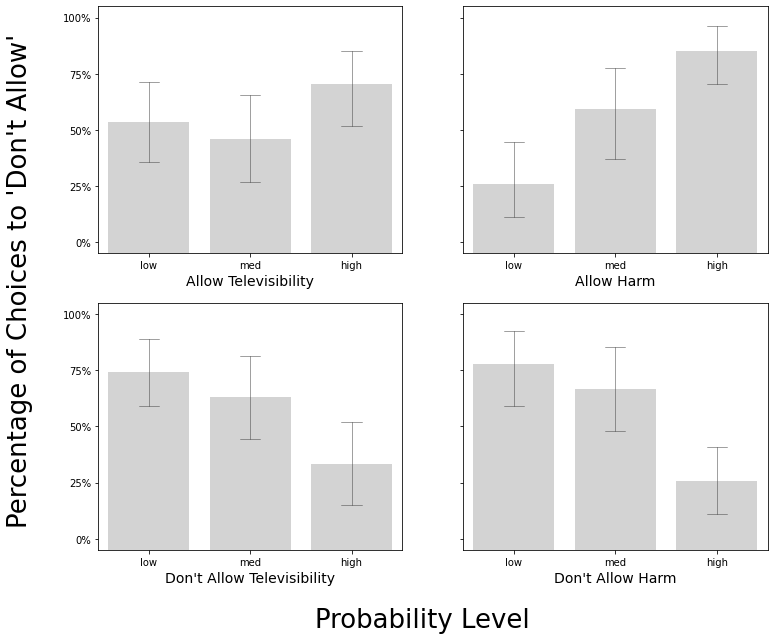

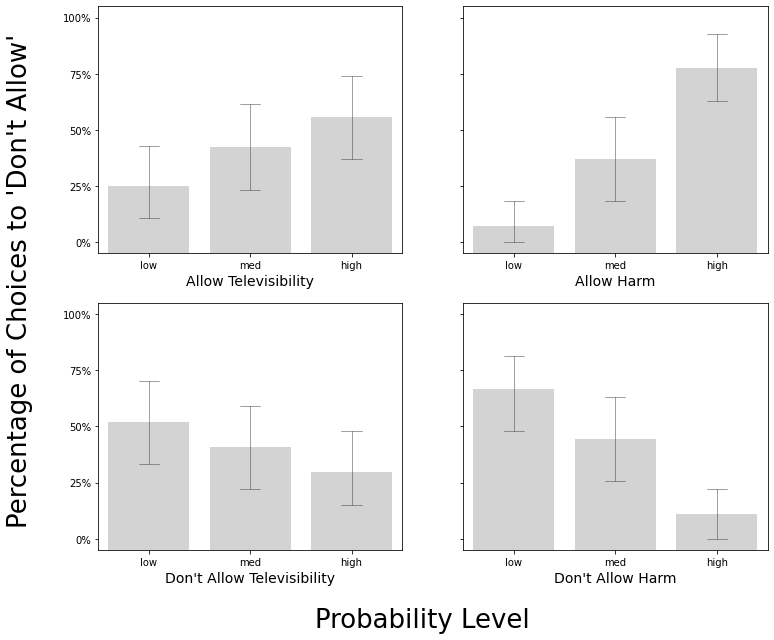

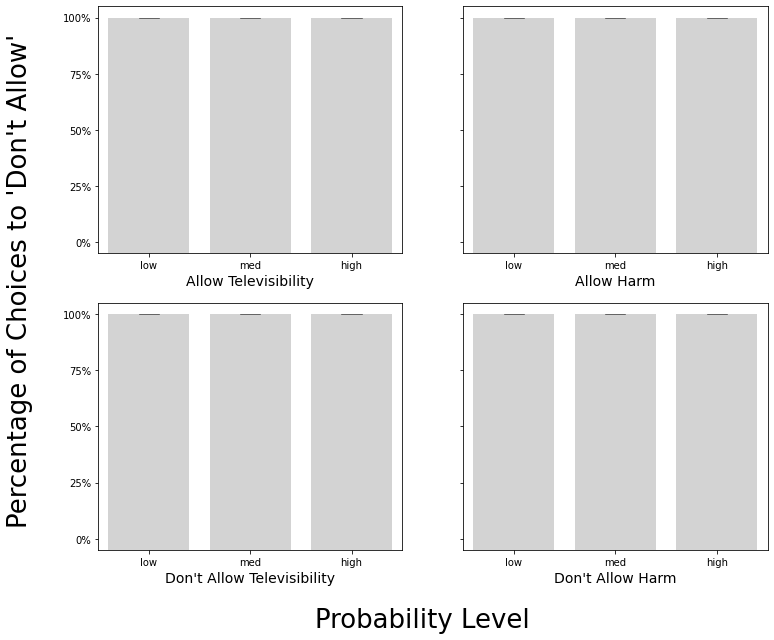

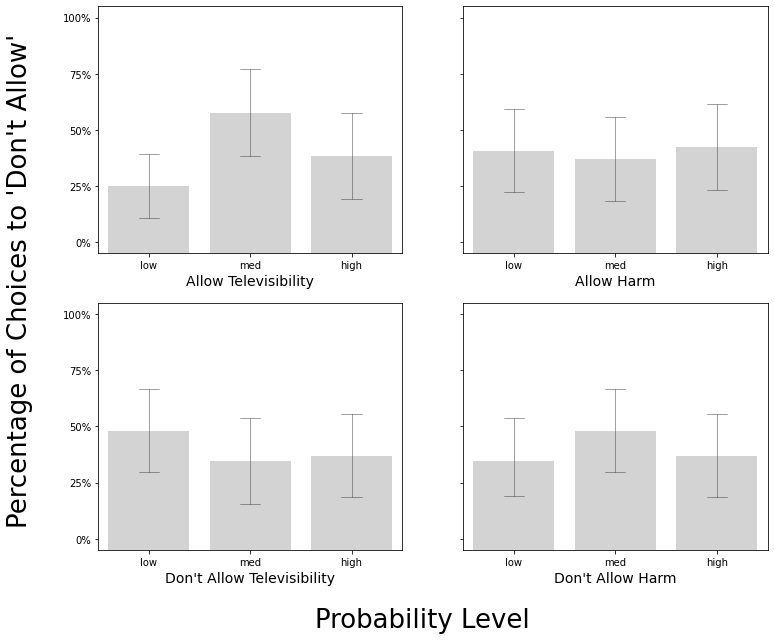

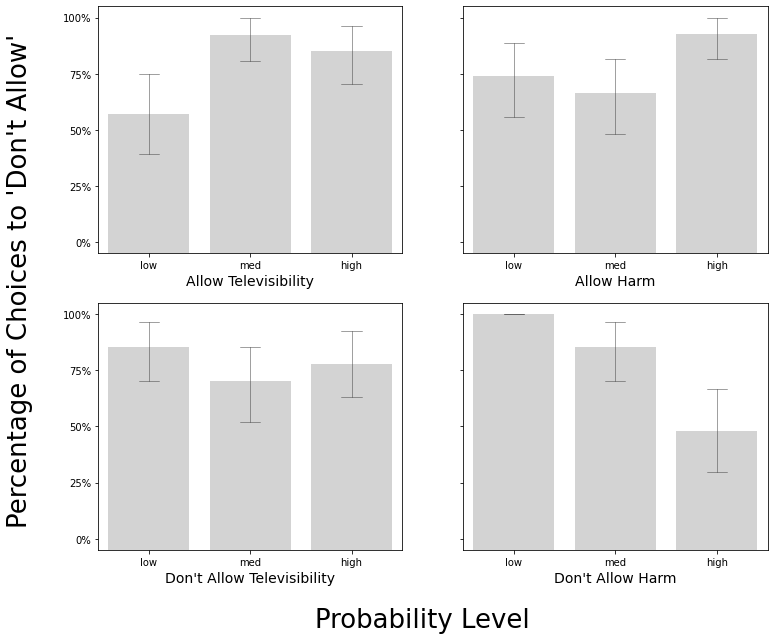

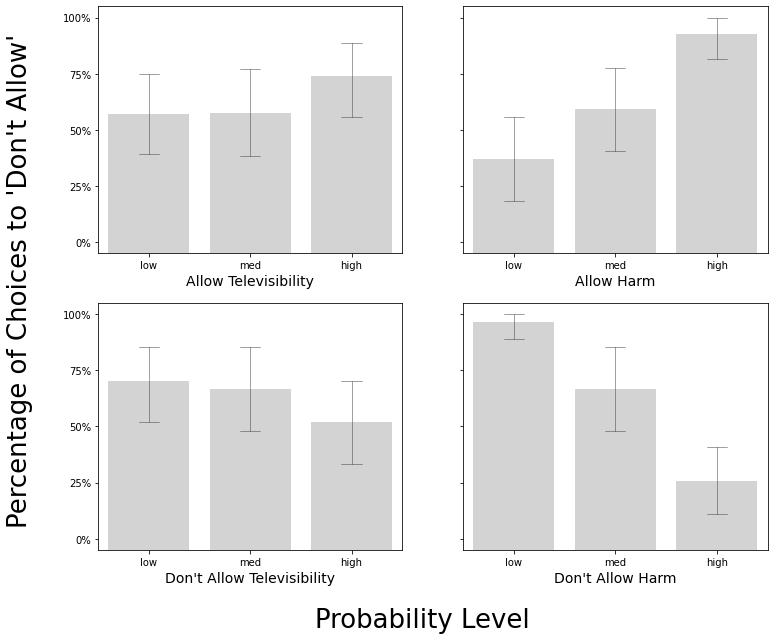

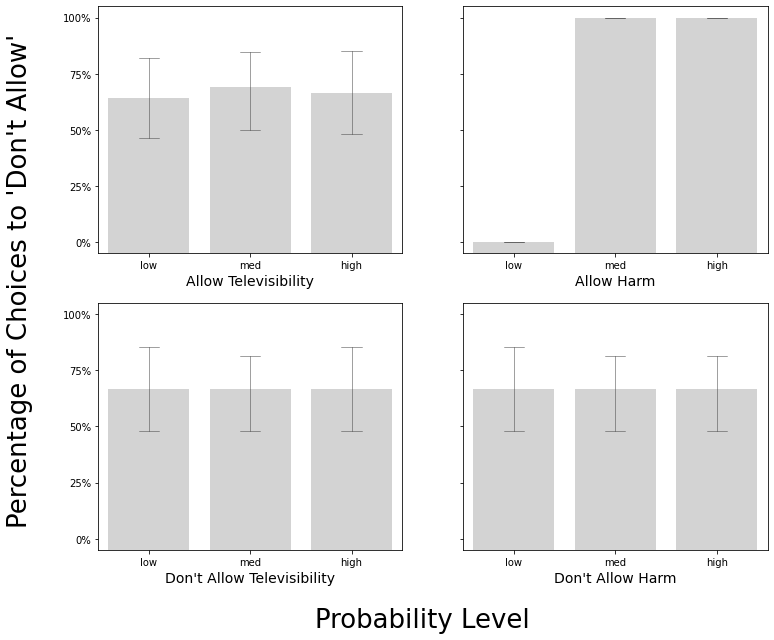

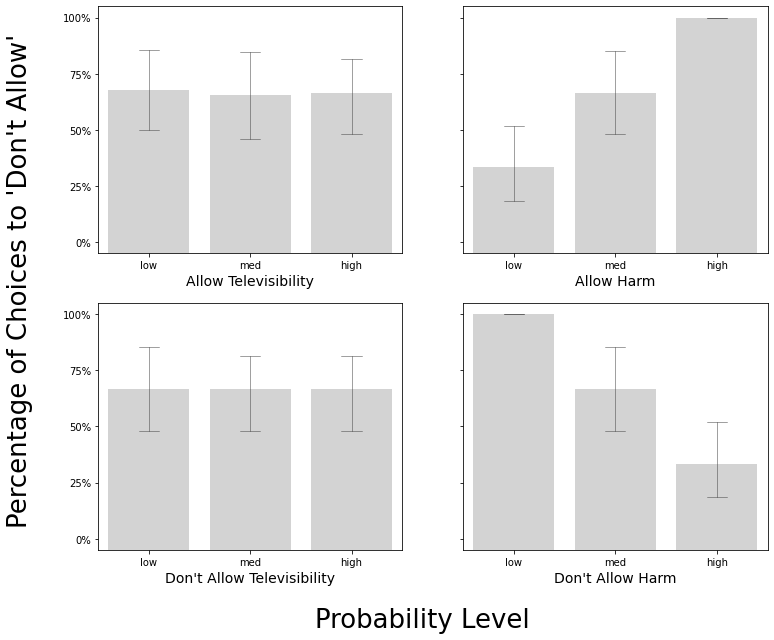

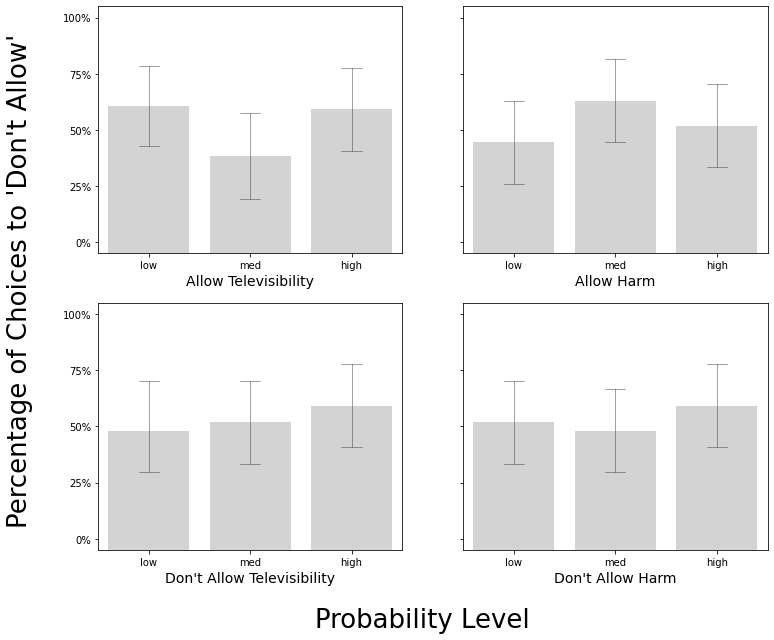

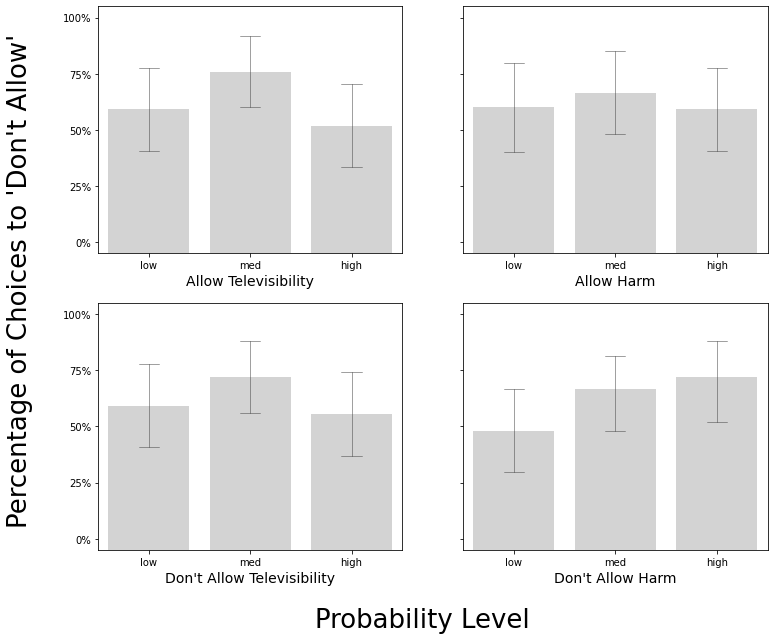

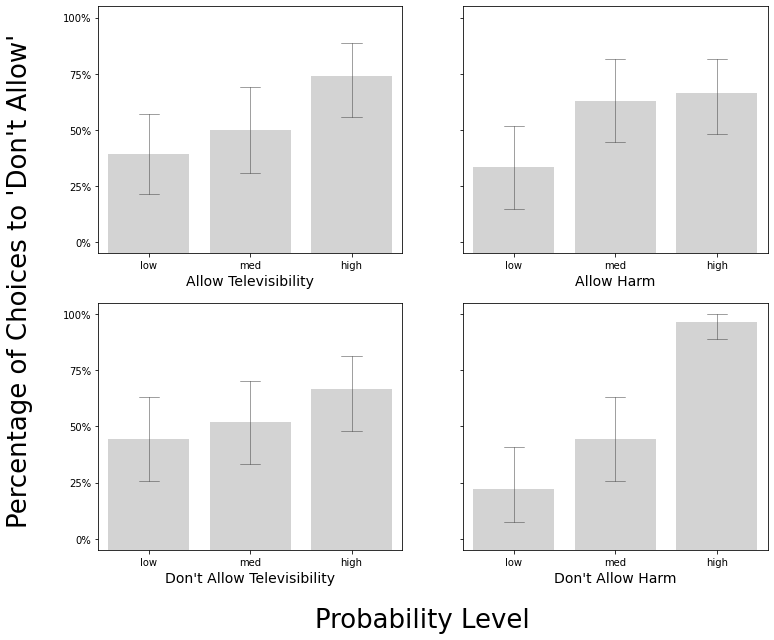

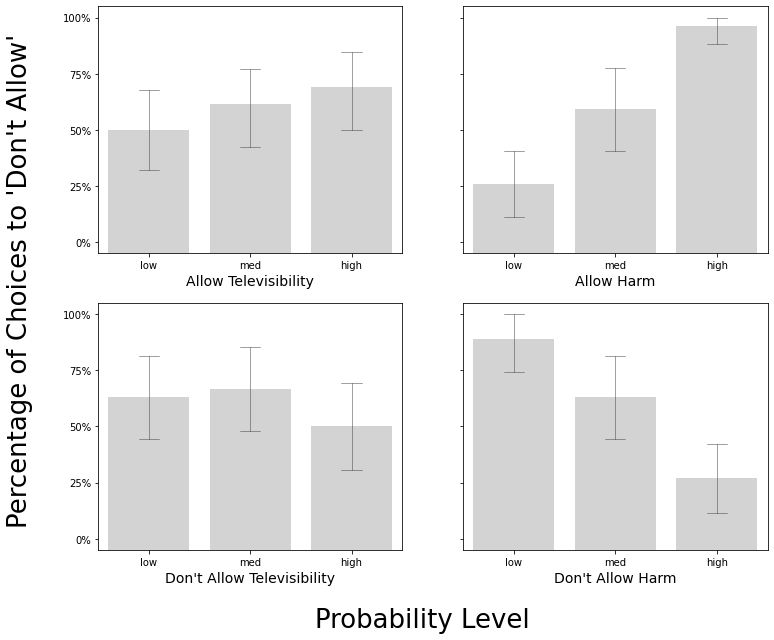

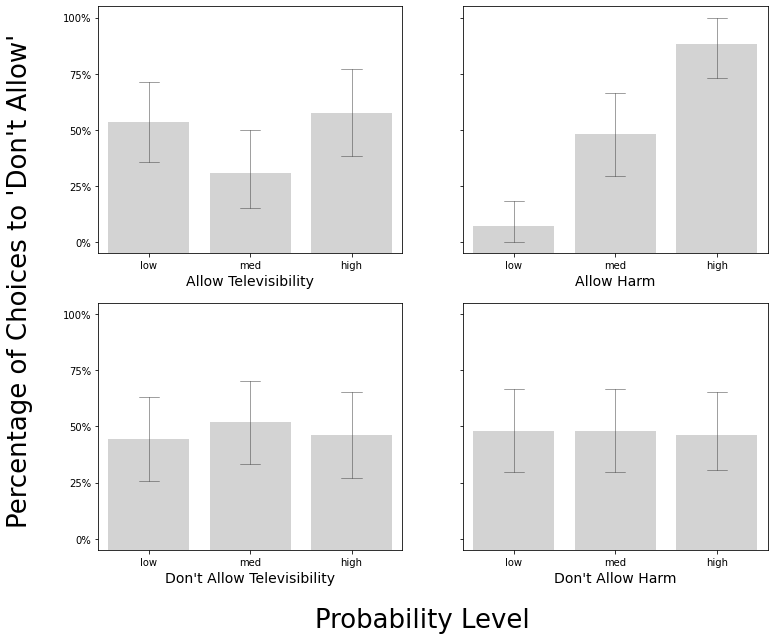

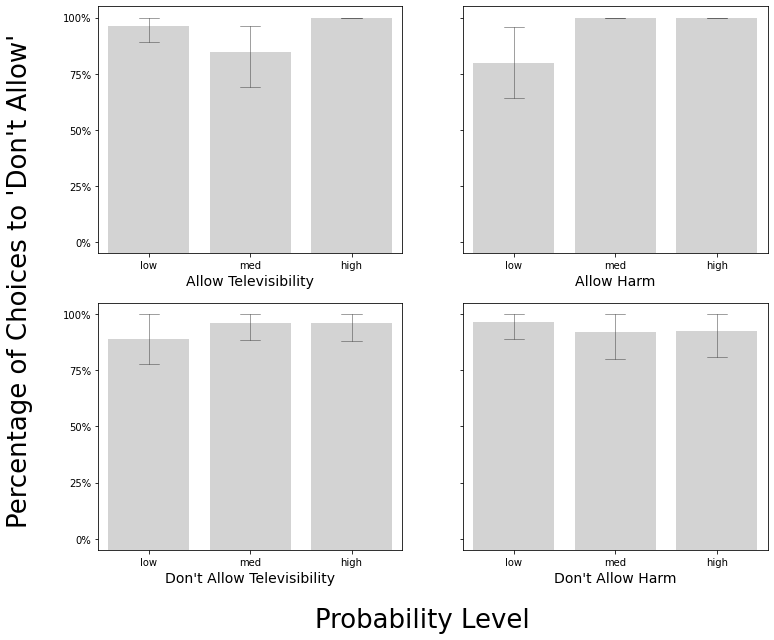

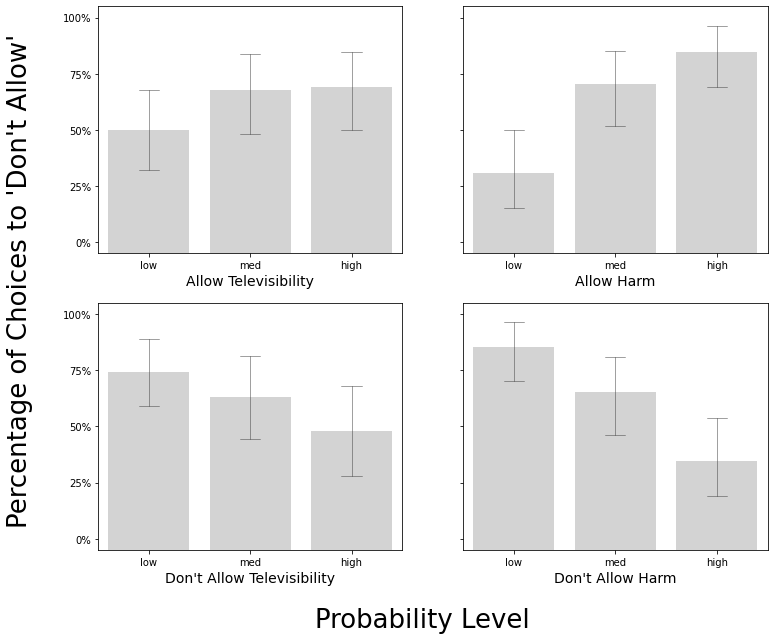

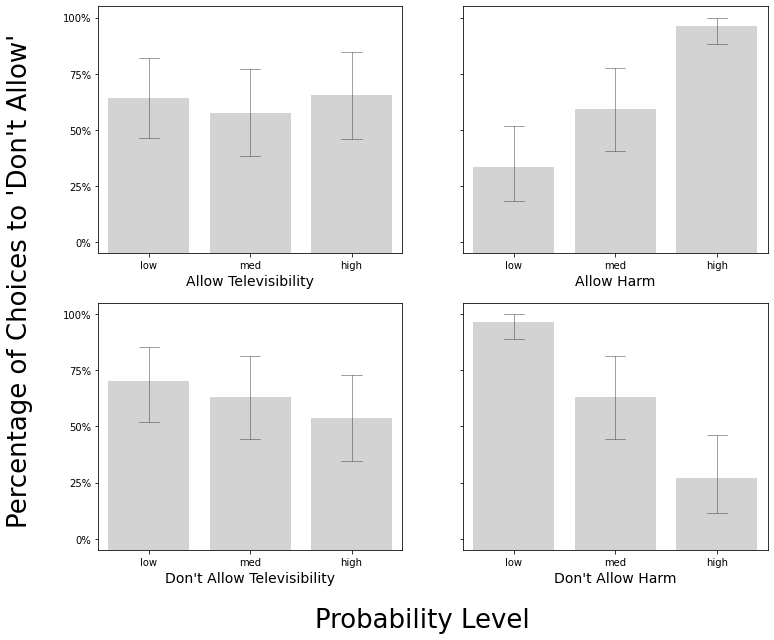

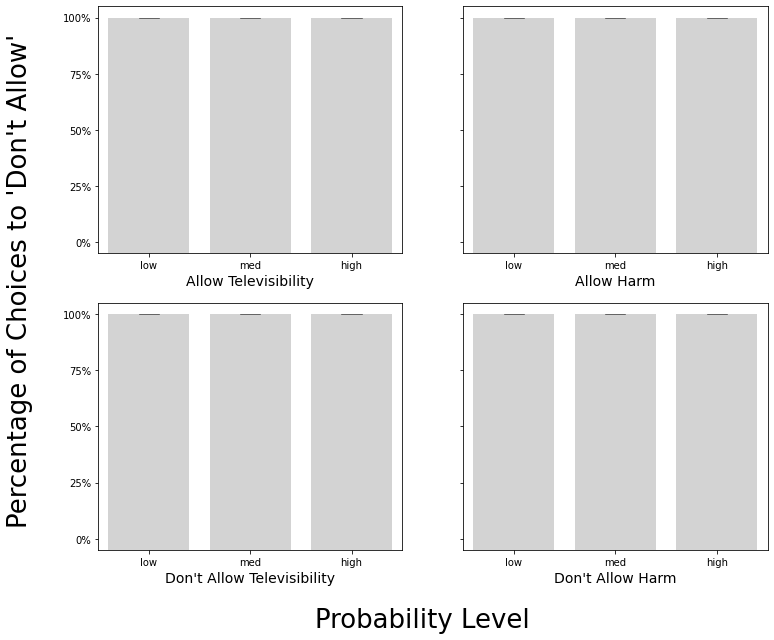

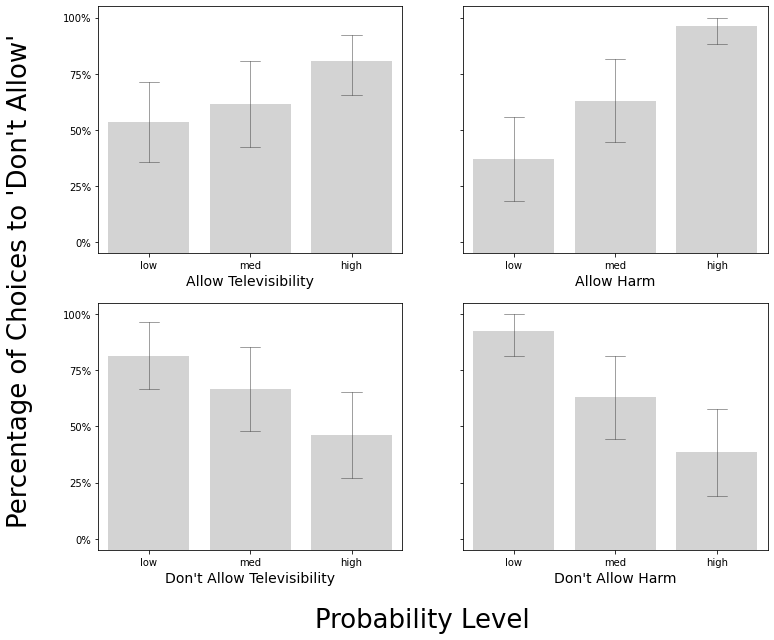

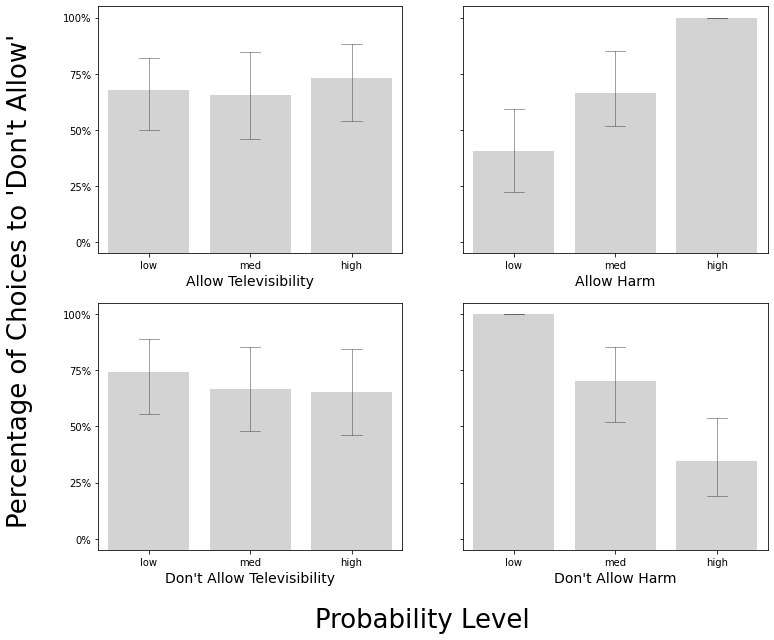

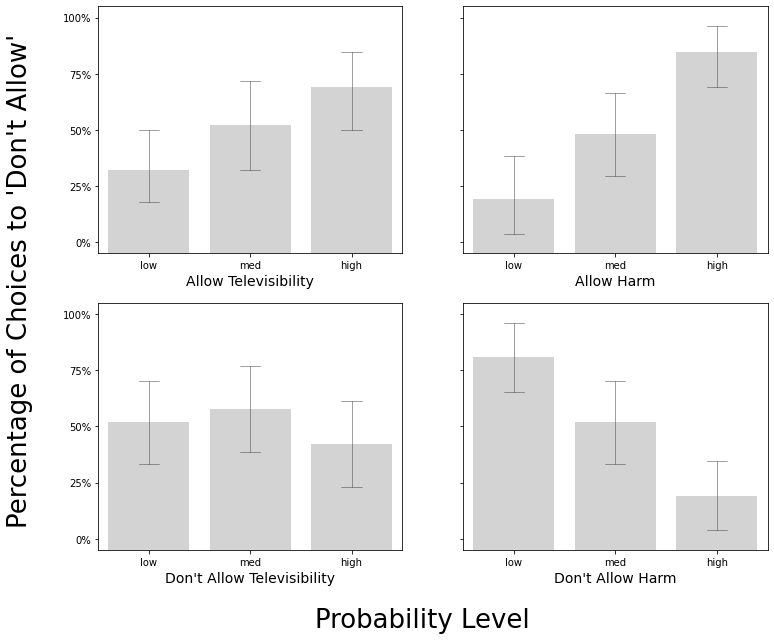

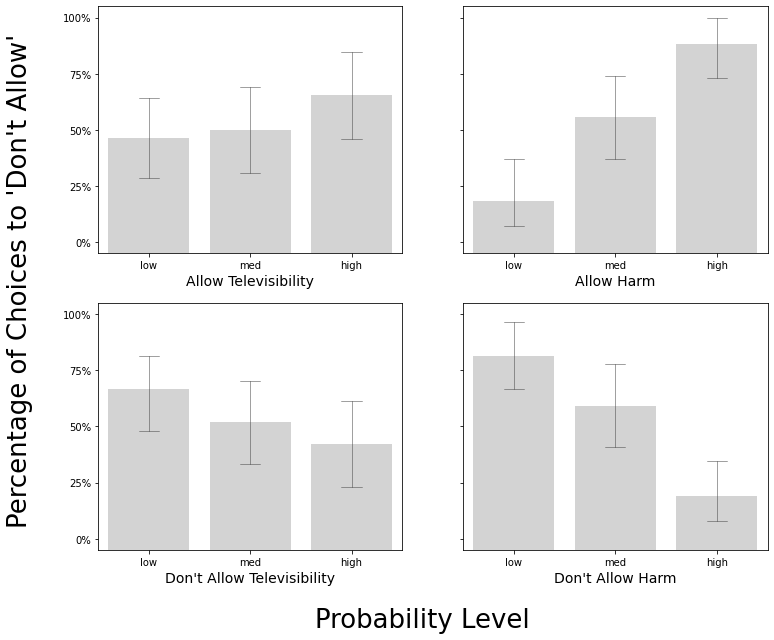

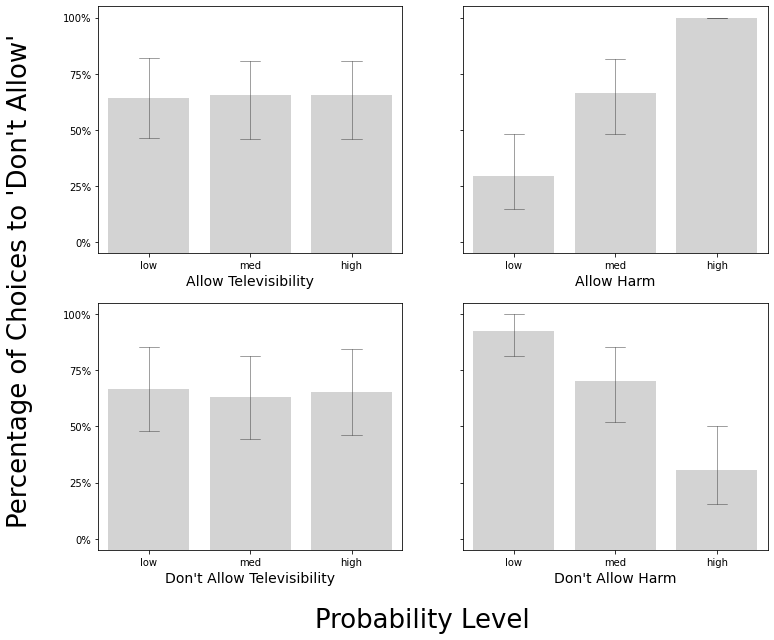

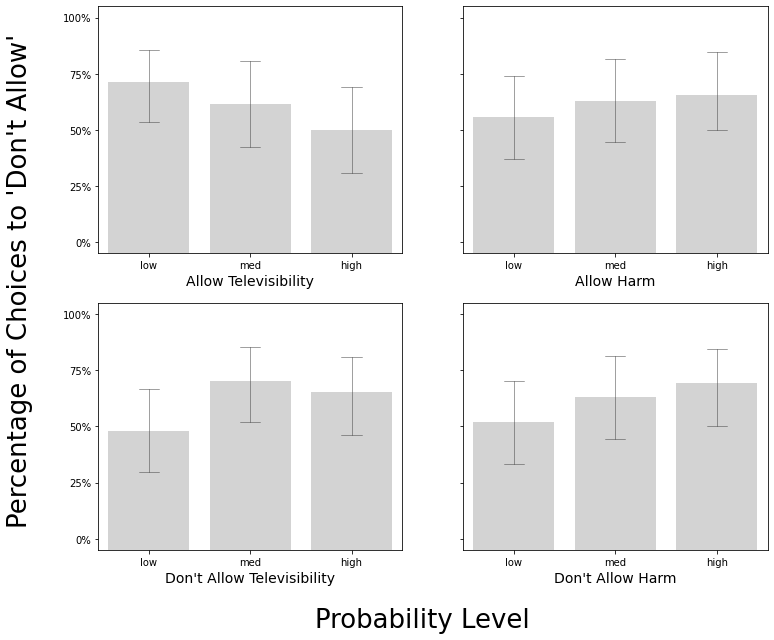

In [42]:
# Calculate OLS model for each participant and show their results along the main IVs
for i in num_df['participant'].unique():
    plot_indiv(df=plot_df, part=i)

#### Fits at the individual level

In [43]:
%time
num_df.drop(['risk'], axis=1, inplace=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [44]:
# Clean up 
num_df = num_df.dropna().reset_index(drop=True)
num_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm
0,0,1,low_low_low_low,0.0,0,0,0,0
1,0,2,low_low_low_low,0.0,0,0,0,0
2,0,3,low_low_low_low,0.0,0,0,0,0
3,0,4,low_low_low_low,0.0,0,0,0,0
4,0,5,low_low_low_low,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
3628,1,41,high_high_high_high,1.0,2,2,2,2
3629,1,42,high_high_high_high,1.0,2,2,2,2
3630,1,43,high_high_high_high,1.0,2,2,2,2
3631,1,44,high_high_high_high,1.0,2,2,2,2


In [45]:
# The model 
model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', random_state=8675309)

# Where we'll save results 
ind_results = pd.DataFrame()

# Loop through the unique participants, isolate their data, fit the model, get the results. 
for uniq_part in num_df['participant'].unique():
    # Isolate their data
    temp_df = num_df[num_df['participant']==uniq_part]

    # Fit the model
    features = temp_df[['first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
    outc = temp_df['choice']
    if np.std(outc)==0:
        results = pd.DataFrame([uniq_part], columns=['participant'])
        ind_results = pd.concat([ind_results, results])
    else:
        clf = model.fit(features, outc)
        beta_weights = list(clf.coef_[0])
        results = pd.DataFrame([uniq_part, 
                                clf.score(features, outc), 
                                beta_weights[0], 
                                beta_weights[1], 
                                beta_weights[2], 
                                beta_weights[3]])
        results = results.T
        results.columns = ['participant', 
                           'score', 
                           'first_tele', 
                           'first_harm', 
                           'sec_tele', 
                           'sec_harm']
        ind_results = pd.concat([ind_results, results])

# Add in group membership label
ind_results['Source'] = [val for val in data['source']]
ind_results['Source'] = ind_results['Source'].replace({'bx_analyst':"Behavior Analyst", 
                                               'gen_pop': "Control Group"})
ind_results

,participant,score,first_tele,first_harm,sec_tele,sec_harm,Source
0,1.0,NaN,NaN,NaN,NaN,NaN,Behavior Analyst
0,2.0,NaN,NaN,NaN,NaN,NaN,Behavior Analyst
0,3.0,0.950617,0.378640,2.235289,-0.366681,-2.365613,Behavior Analyst
0,4.0,0.987654,-1.025490,-1.058244,-0.199348,-0.199348,Behavior Analyst
0,5.0,0.938272,-0.585812,1.995310,0.404955,-2.249966,Behavior Analyst
0,6.0,0.962963,0.505025,2.222248,-0.288927,-1.733168,Behavior Analyst
0,7.0,0.950000,0.890066,2.229690,-0.066153,-2.042269,Behavior Analyst
0,8.0,0.864198,-0.083412,1.691231,-0.094578,0.200347,Behavior Analyst
0,9.0,0.975000,0.811167,2.363187,-0.683782,-2.340643,Behavior Analyst
0,10.0,0.827160,0.396017,0.879373,-0.024263,-1.307567,Behavior Analyst


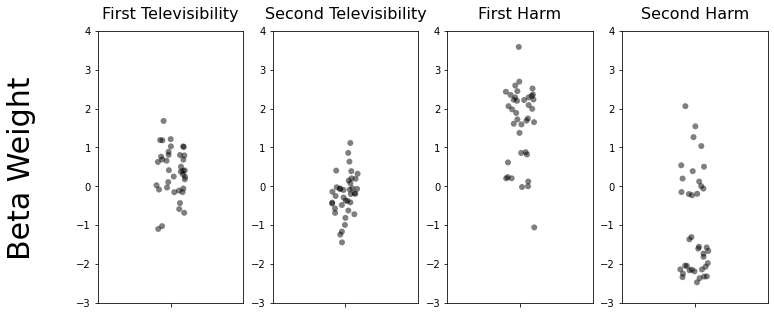

In [46]:
# Choice scenario characteristics
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(12, 5))

# First Televisibility
sns.stripplot(ax=ax[0], y=ind_results['first_tele'], color='k', alpha=0.5, size=6)
ax[0].set_ylim(-3, 4)
ax[0].set_title("First Televisibility", fontsize=16, pad=12)
ax[0].set_ylabel("")

# Second Televisibility
sns.stripplot(ax=ax[1], y=ind_results['sec_tele'], color='k', alpha=0.5, size=6)
ax[1].set_ylim(-3, 4)
ax[1].set_title("Second Televisibility", fontsize=16, pad=12)
ax[1].set_ylabel("")

# First Harm
sns.stripplot(ax=ax[2], y=ind_results['first_harm'], color='k', alpha=0.5, size=6)
ax[2].set_ylim(-3, 4)
ax[2].set_title("First Harm", fontsize=16, pad=12)
ax[2].set_ylabel("")

# Second Harm
sns.stripplot(ax=ax[3], y=ind_results['sec_harm'], color='k', alpha=0.5, size=6)
ax[3].set_ylim(-3, 4)
ax[3].set_title("Second Harm", fontsize=16, pad=12)
ax[3].set_ylabel("")

fig.supylabel("Beta Weight", fontsize=30)
fig.supxlabel("", fontsize=26)
plt.show()

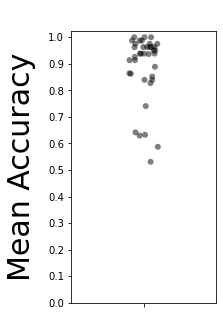

In [47]:
# Mean Accuracy
fig, ax = plt.subplots(figsize=(2.6, 5))
sns.stripplot(y=ind_results['score'], color='k', alpha=0.5, size=6)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0])
plt.ylabel("Mean Accuracy", fontsize=30, labelpad=12)
plt.xlabel("", fontsize=26)
plt.title(" ", fontsize=16, pad=12)
plt.show()

In [48]:
ind_results.describe()

,participant,score,first_tele,first_harm,sec_tele,sec_harm
count,45.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,23.000000,0.888065,0.365722,1.607677,-0.212950,-1.020030
std,13.133926,0.126241,0.631629,0.991219,0.542526,1.311746
min,1.000000,0.530864,-1.097305,-1.058244,-1.443902,-2.471590
25%,12.000000,0.854514,-0.050202,0.864603,-0.472084,-2.139999
50%,23.000000,0.938272,0.402648,1.935953,-0.185225,-1.589467
75%,34.000000,0.962963,0.802908,2.290007,0.053889,-0.010315
max,45.000000,1.000000,1.683636,3.589506,1.116236,2.064101
